This notebook follows the CRISP-DM framework and supports the accompanying report.

__________________
Data understanding
__________________

In [1]:
# Install required packages
!pip install -q torchmetrics mlxtend textblob wordcloud nltk seaborn scikit-learn matplotlib pandas numpy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchmetrics
from sklearn.inspection import permutation_importance
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    mean_squared_error, classification_report, ConfusionMatrixDisplay, 
    roc_curve, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
import nltk

# Keep the same seed for every model
SEED = 42  

# Python random
random.seed(SEED)

# NumPy random
np.random.seed(SEED)

# PyTorch random
torch.manual_seed(SEED)

# GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make cuDNN deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load datasets
df_raw = pd.read_csv("hotel_booking_data.csv")
df_text = pd.read_csv("hotel_reviews.csv")


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Preview dataset
print("Dataset shape:", df_raw.shape)
display(df_raw.head())

# Basic info
df_raw.info()


Dataset shape: (15000, 20)


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Adults,Children,Cancellations,Bookings_not_cancelled,Average_daily_rate,Booking_changes,Parking_spaces,Special_requests,Arrival_month,Meal,Market_segment,Repeated_guest,Reserved_room_type,Assigned_room_type,Deposit_type,Target
0,339,26,3,6,2,0.0,0,0,80.00,0,NaN,0,September,HB,Groups,0.0,A,A,Non Refund,1
1,323,17,0,4,1,0.0,0,0,86.00,1,0.0,0,May,HB,Offline TA/TO,0.0,A,B,No Deposit,0
2,26,5,2,5,2,0.0,0,0,64.00,0,0.0,0,April,BB,Online TA,0.0,A,A,No Deposit,0
3,193,28,0,3,2,1.0,0,0,98.50,0,0.0,1,July,BB,Direct,0.0,A,A,No Deposit,0
4,15,11,2,4,2,0.0,0,0,92.17,0,0.0,0,October,BB,Online TA,0.0,A,A,No Deposit,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Days_before_arrival     15000 non-null  int64  
 1   Arrival_day_of_month    15000 non-null  int64  
 2   Weekend_nights          15000 non-null  int64  
 3   Week_nights             15000 non-null  int64  
 4   Adults                  15000 non-null  int64  
 5   Children                14250 non-null  float64
 6   Cancellations           15000 non-null  int64  
 7   Bookings_not_cancelled  15000 non-null  int64  
 8   Average_daily_rate      15000 non-null  float64
 9   Booking_changes         15000 non-null  int64  
 10  Parking_spaces          14250 non-null  float64
 11  Special_requests        15000 non-null  int64  
 12  Arrival_month           15000 non-null  object 
 13  Meal                    15000 non-null  object 
 14  Market_segment          15000 non-null

In [3]:
# Summary statistics for numerical variables
numeric_cols = ['Days_before_arrival', 'Arrival_day_of_month', 'Weekend_nights', 
                'Week_nights', 'Adults', 'Children', 'Cancellations', 
                'Bookings_not_cancelled', 'Booking_changes', 'Average_daily_rate', 
                'Parking_spaces', 'Special_requests']

print("\nSummary statistics:")
display(df_raw[numeric_cols].describe())


Summary statistics:


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Adults,Children,Cancellations,Bookings_not_cancelled,Booking_changes,Average_daily_rate,Parking_spaces,Special_requests
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14250.000000,15000.000000,15000.000000,15000.00000,15000.000000,14250.000000,15000.000000
mean,103.893067,15.652000,0.918267,2.488533,1.851333,0.106456,0.088333,0.135733,0.22140,102.309155,0.062316,0.562133
std,106.828004,8.812805,0.994411,1.910945,0.600824,0.404334,0.819375,1.421447,0.67321,64.726648,0.242895,0.789629
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,18.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.00000,69.000000,0.000000,0.000000
50%,69.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.00000,94.500000,0.000000,0.000000
75%,159.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.00000,126.000000,0.000000,1.000000
max,629.000000,31.000000,19.000000,50.000000,27.000000,3.000000,26.000000,66.000000,17.00000,5400.000000,2.000000,5.000000


In [4]:
# Check for missing values
print("\nMissing values per column:")
display(df_raw.isnull().sum())


Missing values per column:


Days_before_arrival         0
Arrival_day_of_month        0
Weekend_nights              0
Week_nights                 0
Adults                      0
Children                  750
Cancellations               0
Bookings_not_cancelled      0
Average_daily_rate          0
Booking_changes             0
Parking_spaces            750
Special_requests            0
Arrival_month               0
Meal                        0
Market_segment              0
Repeated_guest            750
Reserved_room_type          0
Assigned_room_type          0
Deposit_type                0
Target                      0
dtype: int64

In [5]:
# Count unique values for categorical variables
categorical_cols = ['Arrival_month', 'Meal', 'Market_segment', 'Repeated_guest',
                    'Reserved_room_type', 'Assigned_room_type', 'Deposit_type', 'Target']

for col in categorical_cols:
    print(f"\n{col}: {df_raw[col].nunique()} unique values")


Arrival_month: 12 unique values

Meal: 5 unique values

Market_segment: 7 unique values

Repeated_guest: 2 unique values

Reserved_room_type: 10 unique values

Assigned_room_type: 11 unique values

Deposit_type: 3 unique values

Target: 2 unique values


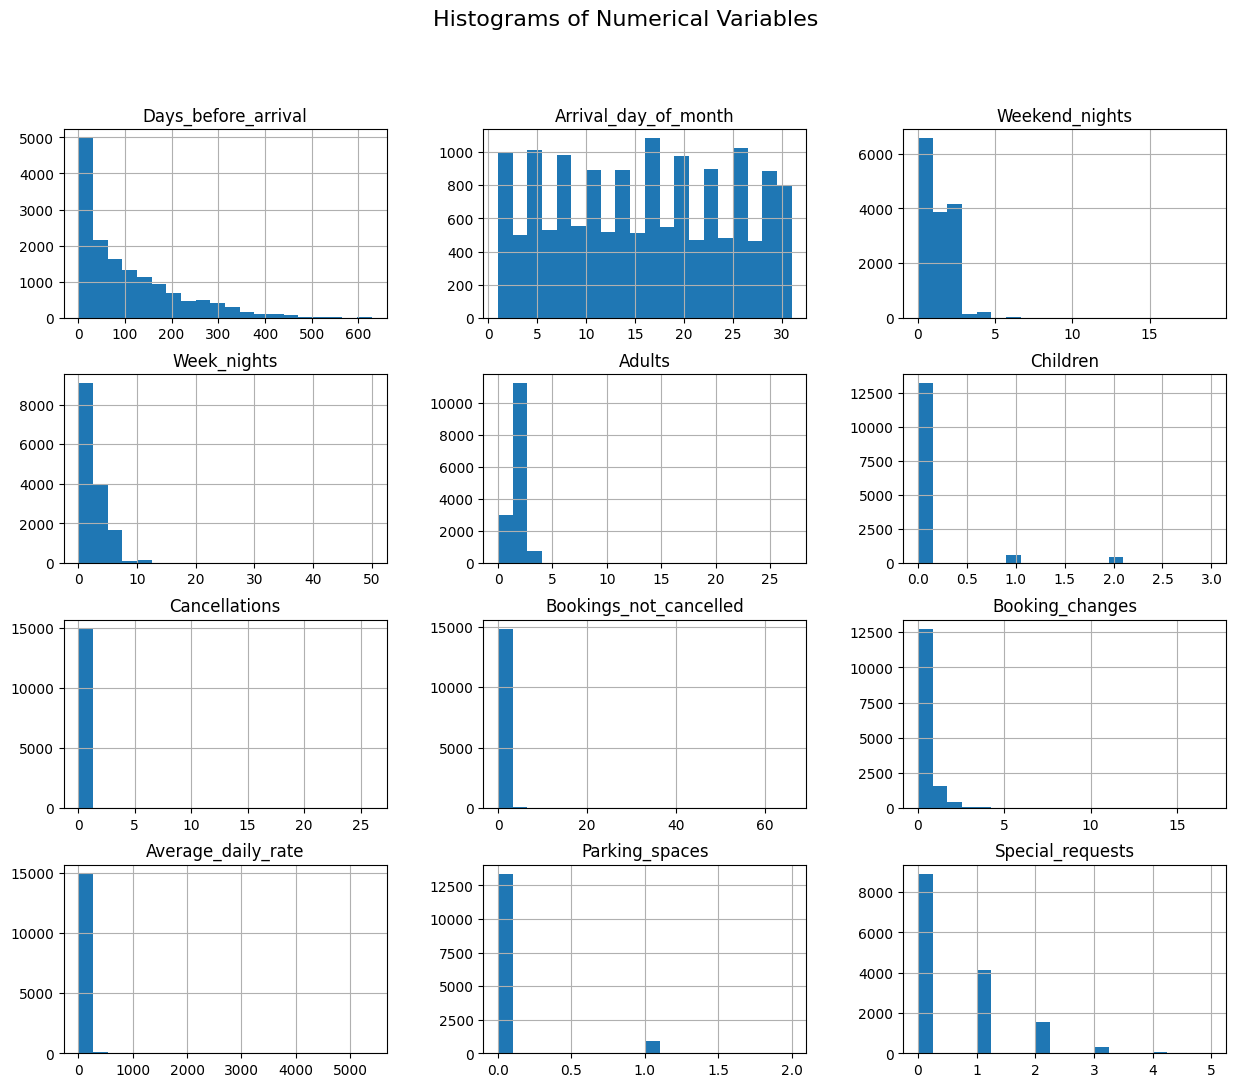

In [6]:
# 1. Histogram for numerical variables
df_raw[numeric_cols].hist(bins=20, figsize=(15, 12))
plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.show()

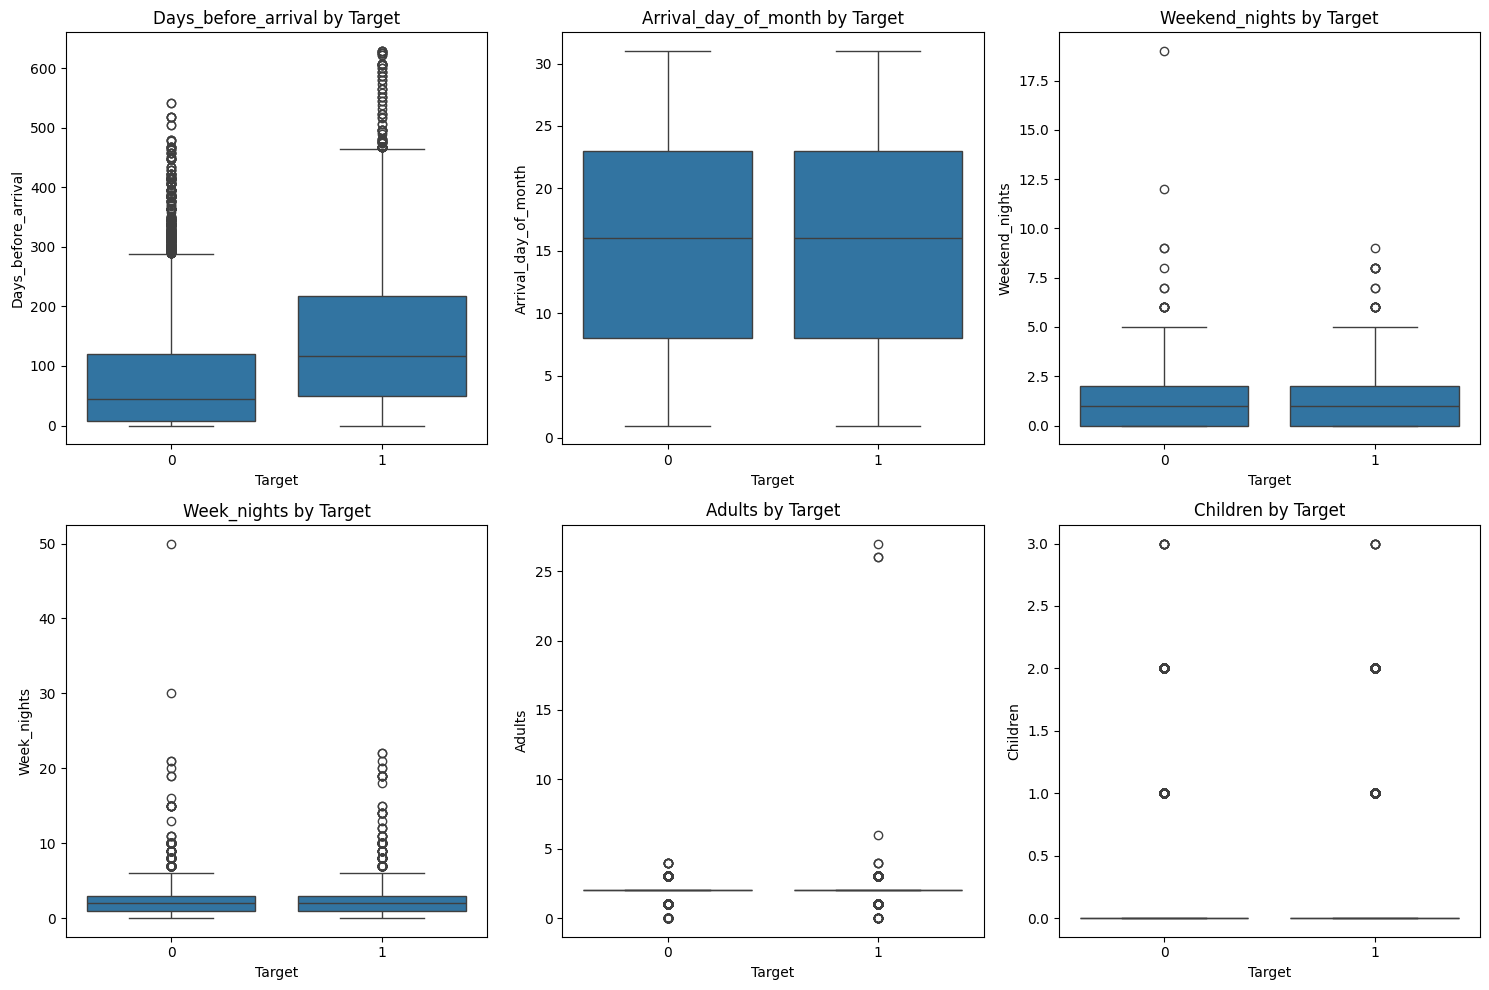

In [7]:
# 2. Boxplots for numerical variables vs. Target (Cancellation)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6], 1):  # first 6 for layout
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_raw, x="Target", y=col)
    plt.title(f"{col} by Target")
plt.tight_layout()
plt.show()

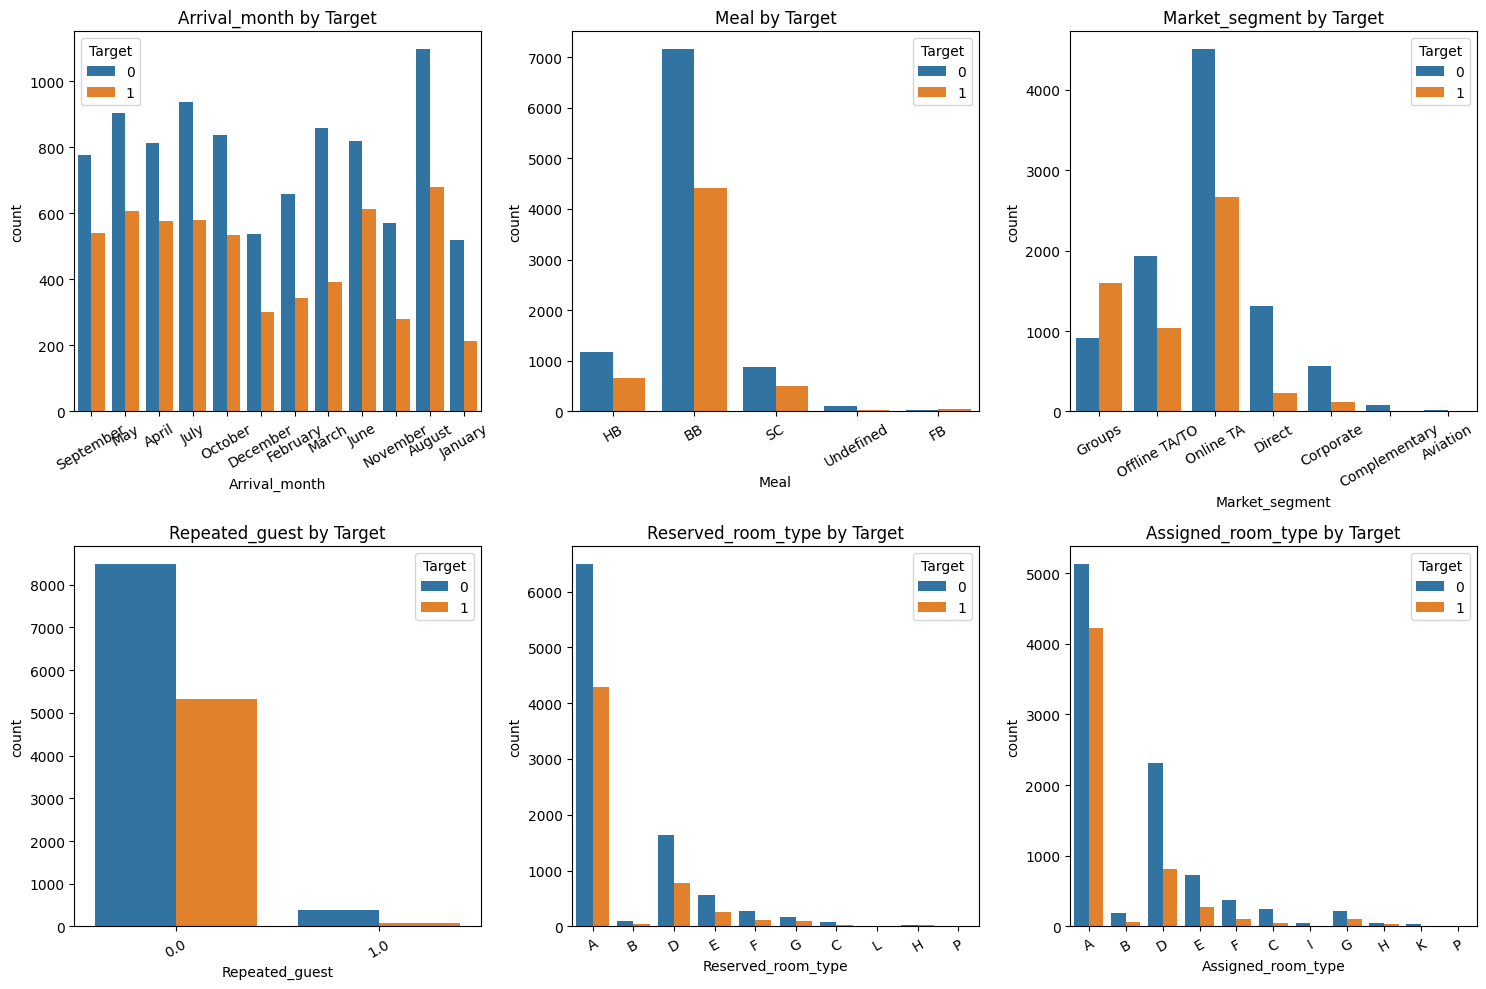

In [8]:
# 3. Count plots for categorical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols[:-1][:6], 1):  # exclude Target
    plt.subplot(2, 3, i)
    sns.countplot(data=df_raw, x=col, hue="Target")
    plt.title(f"{col} by Target")
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

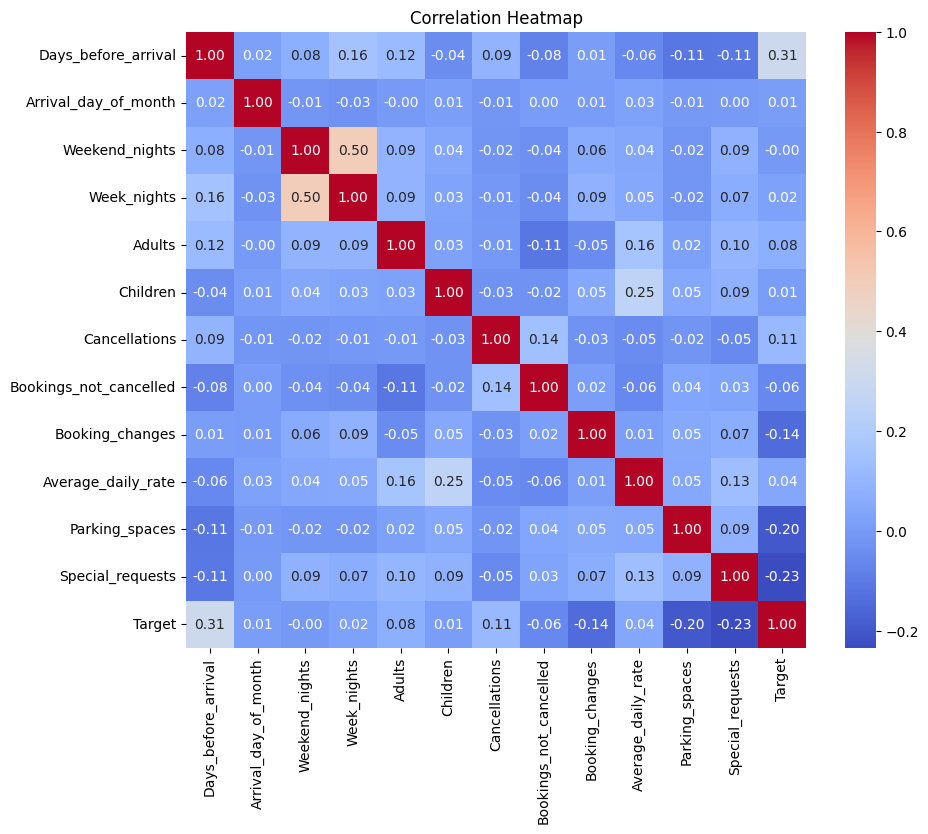

In [9]:
# 4. Correlation heatmap (numeric features only)
plt.figure(figsize=(10, 8))
corr = df_raw[numeric_cols + ['Target']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

________________
Data Preparation
________________

Handling missing values

In [10]:
# Check missing values
missing = df_raw.isnull().sum().sort_values(ascending=False)
missing_percent = (df_raw.isnull().mean() * 100).sort_values(ascending=False)
print("Missing values (%):\n", pd.concat([missing, missing_percent], axis=1, keys=['Count', 'Percent']))


Missing values (%):
                         Count  Percent
Parking_spaces            750      5.0
Repeated_guest            750      5.0
Children                  750      5.0
Days_before_arrival         0      0.0
Week_nights                 0      0.0
Weekend_nights              0      0.0
Arrival_day_of_month        0      0.0
Cancellations               0      0.0
Bookings_not_cancelled      0      0.0
Average_daily_rate          0      0.0
Booking_changes             0      0.0
Adults                      0      0.0
Special_requests            0      0.0
Arrival_month               0      0.0
Meal                        0      0.0
Market_segment              0      0.0
Reserved_room_type          0      0.0
Assigned_room_type          0      0.0
Deposit_type                0      0.0
Target                      0      0.0


In [11]:
# Snapshot before modifying
df_clean = df_raw.copy()

# Handle missing values
df_clean['Parking_spaces'].fillna(df_clean['Parking_spaces'].median(), inplace=True)
df_clean['Children'].fillna(df_clean['Children'].median(), inplace=True)
df_clean['Repeated_guest'].fillna(df_clean['Repeated_guest'].mode()[0], inplace=True)


print("Missing values after imputation:\n", df_clean.isnull().sum().sum())

Missing values after imputation:
 0


/tmp/ipykernel_266/3190630525.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Parking_spaces'].fillna(df_clean['Parking_spaces'].median(), inplace=True)
/tmp/ipykernel_266/3190630525.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

Outliers

In [12]:
# Detect outliers
numeric_cols = df_clean.select_dtypes(include=['int64']).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
    outlier_summary[col] = len(outliers)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_count'])
outlier_df['Outlier_%'] = 100 * outlier_df['Outlier_count'] / len(df_clean)
display(outlier_df.sort_values('Outlier_%', ascending=False))


,Outlier_count,Outlier_%
Adults,3768,25.120000
Booking_changes,2246,14.973333
Cancellations,848,5.653333
Bookings_not_cancelled,460,3.066667
Week_nights,412,2.746667
Days_before_arrival,371,2.473333
Special_requests,353,2.353333
Weekend_nights,33,0.220000
Arrival_day_of_month,0,0.000000
Target,0,0.000000


In [13]:
# Create a snapshot of the original data
df_before = df_raw.copy()

# Cap the outliers
def cap_outliers(df_clean, cols):
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])
    return df_clean

df_clean = cap_outliers(df_clean, numeric_cols)


In [14]:
# Check to see number of outliers after capping
numeric_cols = df_clean.select_dtypes(include=['int64']).columns

outlier_check = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    count_outside = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_check[col] = count_outside

check_df = pd.DataFrame.from_dict(outlier_check, orient='index', columns=['Remaining_outliers'])
check_df['Remaining_%'] = (check_df['Remaining_outliers'] / len(df_clean)) * 100
display(check_df.sort_values('Remaining_%', ascending=False))

,Remaining_outliers,Remaining_%


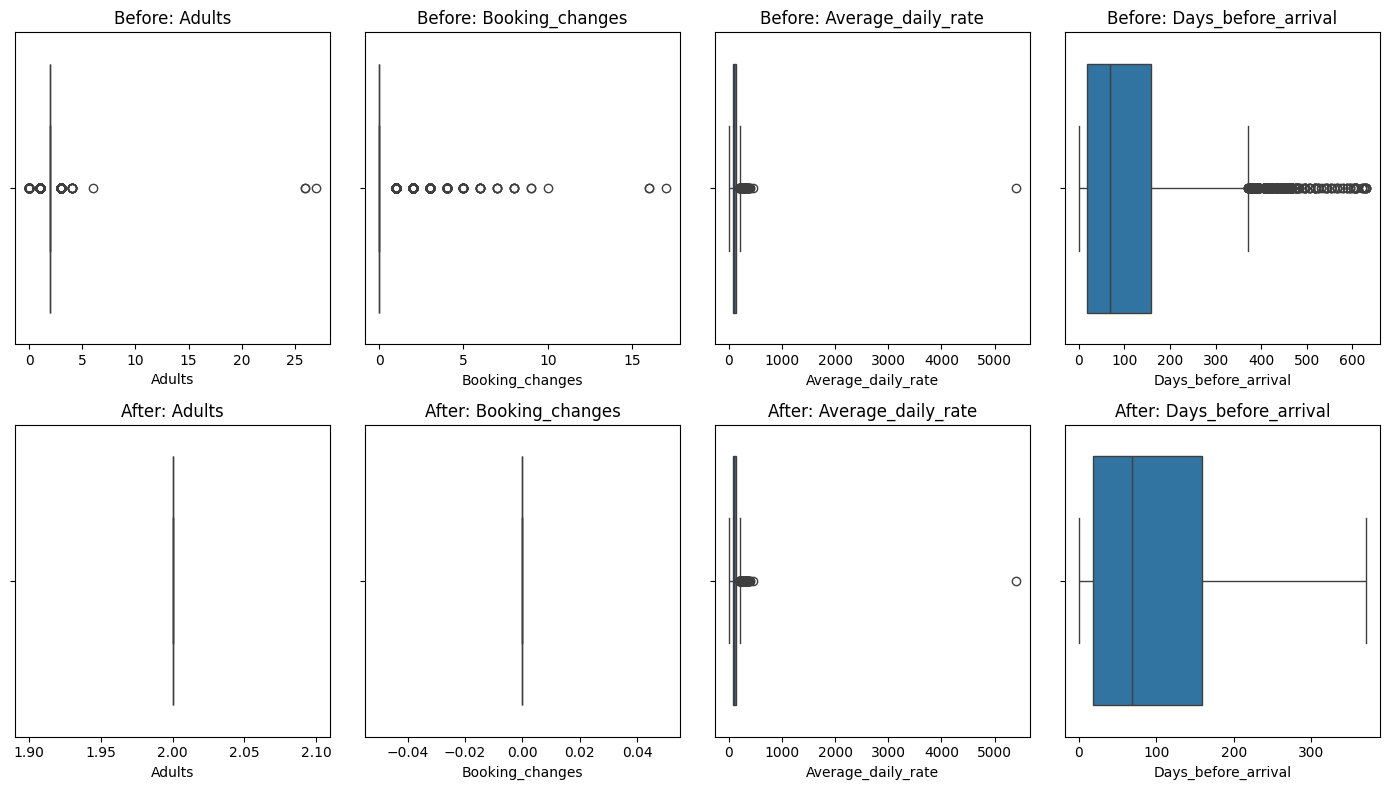

In [15]:
# Visualize after capping
cols_to_plot = ['Adults', 'Booking_changes', 'Average_daily_rate', 'Days_before_arrival']

plt.figure(figsize=(14, 8))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df_before[col])
    plt.title(f"Before: {col}")
    plt.subplot(2, 4, i+4)
    sns.boxplot(x=df_clean[col])
    plt.title(f"After: {col}")
plt.tight_layout()
plt.show()


Infrequent categories

In [16]:
# Find rare categories (<1% of total)
for col in ['Meal', 'Market_segment', 'Reserved_room_type', 'Assigned_room_type']:
    freq = df_clean[col].value_counts(normalize=True)
    rare = freq[freq < 0.01]
    if not rare.empty:
        print(f"{col} - Rare categories:\n{rare}\n")


Meal - Rare categories:
Meal
Undefined    0.009400
FB           0.005333
Name: proportion, dtype: float64

Market_segment - Rare categories:
Market_segment
Complementary    0.005800
Aviation         0.001667
Name: proportion, dtype: float64

Reserved_room_type - Rare categories:
Reserved_room_type
B    0.009133
C    0.006933
H    0.004200
P    0.000133
L    0.000067
Name: proportion, dtype: float64

Assigned_room_type - Rare categories:
Assigned_room_type
H    0.005200
I    0.003400
K    0.002733
P    0.000133
Name: proportion, dtype: float64



In [17]:
# Combine rare categories (<1%) into "Other"
for col in ['Meal', 'Market_segment', 'Reserved_room_type', 'Assigned_room_type']:
    freq = df_clean[col].value_counts(normalize=True)
    rare_cats = freq[freq < 0.01].index
    df_clean[col] = df_clean[col].replace(rare_cats, 'Other')


In [18]:
# Check if combining worked
for col in ['Meal', 'Market_segment', 'Reserved_room_type', 'Assigned_room_type']:
    print(f"\n{col} value counts after replacement:")
    print(df_clean[col].value_counts(normalize=True).round(3))



Meal value counts after replacement:
Meal
BB       0.771
HB       0.122
SC       0.092
Other    0.015
Name: proportion, dtype: float64

Market_segment value counts after replacement:
Market_segment
Online TA        0.478
Offline TA/TO    0.199
Groups           0.167
Direct           0.103
Corporate        0.045
Other            0.007
Name: proportion, dtype: float64

Reserved_room_type value counts after replacement:
Reserved_room_type
A        0.719
D        0.162
E        0.055
F        0.025
Other    0.020
G        0.018
Name: proportion, dtype: float64

Assigned_room_type value counts after replacement:
Assigned_room_type
A        0.623
D        0.208
E        0.067
F        0.033
G        0.022
C        0.019
B        0.017
Other    0.011
Name: proportion, dtype: float64


Feature importance (redundancy check)

In [19]:
# Step 1: identify numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Step 2: sanity check
if len(numeric_cols) == 0:
    print("No numeric columns found for variance check.")
else:
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(df_clean[numeric_cols])

    low_var_cols = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.01]
    print("Low variance columns:", low_var_cols)

# Correlation based
corr_matrix = df_clean[numeric_cols].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.85)]
print("Highly correlated columns:", high_corr_cols)



Low variance columns: ['Adults', 'Cancellations', 'Bookings_not_cancelled', 'Booking_changes']
Highly correlated columns: []


In [20]:
# Variance check
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_clean.select_dtypes(include=['int64', 'float64']))

variances = pd.Series(selector.variances_, index=df_clean.select_dtypes(include=['int64', 'float64']).columns)
print(variances.sort_values())


Cancellations                 0.000000
Bookings_not_cancelled        0.000000
Adults                        0.000000
Booking_changes               0.000000
Repeated_guest                0.029914
Parking_spaces                0.056229
Children                      0.155839
Target                        0.235051
Special_requests              0.546385
Weekend_nights                0.919831
Week_nights                   2.294926
Arrival_day_of_month         77.660363
Average_daily_rate         4189.259604
Days_before_arrival       10208.824666
dtype: float64


In [21]:
# Drop zero-variance columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
zero_var_cols = df_clean[numeric_cols].loc[:, df_clean[numeric_cols].var() == 0].columns
df_clean.drop(columns=zero_var_cols, inplace=True)
display(df_clean.head())
print(df_clean.shape)


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Children,Average_daily_rate,Parking_spaces,Special_requests,Arrival_month,Meal,Market_segment,Repeated_guest,Reserved_room_type,Assigned_room_type,Deposit_type,Target
0,339.0,26.0,3.0,6.0,0.0,80.00,0.0,0.0,September,HB,Groups,0.0,A,A,Non Refund,1.0
1,323.0,17.0,0.0,4.0,0.0,86.00,0.0,0.0,May,HB,Offline TA/TO,0.0,A,B,No Deposit,0.0
2,26.0,5.0,2.0,5.0,0.0,64.00,0.0,0.0,April,BB,Online TA,0.0,A,A,No Deposit,0.0
3,193.0,28.0,0.0,3.0,1.0,98.50,0.0,1.0,July,BB,Direct,0.0,A,A,No Deposit,0.0
4,15.0,11.0,2.0,4.0,0.0,92.17,0.0,0.0,October,BB,Online TA,0.0,A,A,No Deposit,0.0


(15000, 16)


Encode categorical variables

In [22]:
df_clean_encoded = df_clean.copy()  # snapshot before encoding

# encode categorical variables

binary_cols = [col for col in categorical_cols if df_clean_encoded[col].nunique() == 2]
multi_cat_cols = [col for col in categorical_cols if df_clean_encoded[col].nunique() > 2]

le = LabelEncoder()
for col in binary_cols:
    df_clean_encoded[col] = le.fit_transform(df_clean_encoded[col])

df_clean_encoded = pd.get_dummies(df_clean_encoded, columns=multi_cat_cols, drop_first=True)
print("Categorical variables encoded.")




Categorical variables encoded.


In [23]:
print("Checking binary-encoded columns:\n")
for col in binary_cols:
    if col in df_clean_encoded.columns:
        unique_vals = df_clean_encoded[col].unique()
        print(f"{col}: unique values = {unique_vals}")


Checking binary-encoded columns:

Repeated_guest: unique values = [0 1]
Target: unique values = [1 0]


In [24]:
print("\n One-hot encoded columns (sample):")
dummy_cols = [col for col in df_clean_encoded.columns if any(base in col for base in multi_cat_cols)]
print(dummy_cols[:20])  # show first 20



 One-hot encoded columns (sample):
['Arrival_month_August', 'Arrival_month_December', 'Arrival_month_February', 'Arrival_month_January', 'Arrival_month_July', 'Arrival_month_June', 'Arrival_month_March', 'Arrival_month_May', 'Arrival_month_November', 'Arrival_month_October', 'Arrival_month_September', 'Meal_HB', 'Meal_Other', 'Meal_SC', 'Market_segment_Direct', 'Market_segment_Groups', 'Market_segment_Offline TA/TO', 'Market_segment_Online TA', 'Market_segment_Other', 'Reserved_room_type_D']


In [25]:
print("\nBefore encoding:", len(categorical_cols), "categorical variables")
print("After encoding:", df_clean_encoded.shape[1], "total columns")



Before encoding: 8 categorical variables
After encoding: 43 total columns


Scale numeric features

In [26]:
df_clean_encoded_scaled = df_clean_encoded.copy()

# Scale numeric features

scaler = StandardScaler()

# Recalculate numeric columns after cleaning and encoding
numeric_cols = df_clean_encoded_scaled.select_dtypes(include=['int64', 'float64']).columns

# Scale only numeric columns
df_clean_encoded_scaled[numeric_cols] = scaler.fit_transform(df_clean_encoded_scaled[numeric_cols])

# Check scaling results
means = df_clean_encoded_scaled[numeric_cols].mean().round(2)
stds = df_clean_encoded_scaled[numeric_cols].std().round(2)

print("\nFeature means after scaling:\n", means)
print("\nFeature standard deviations after scaling:\n", stds)





Feature means after scaling:
 Days_before_arrival     0.0
Arrival_day_of_month    0.0
Weekend_nights         -0.0
Week_nights            -0.0
Children                0.0
Average_daily_rate      0.0
Parking_spaces          0.0
Special_requests       -0.0
Repeated_guest         -0.0
Target                  0.0
dtype: float64

Feature standard deviations after scaling:
 Days_before_arrival     1.0
Arrival_day_of_month    1.0
Weekend_nights          1.0
Week_nights             1.0
Children                1.0
Average_daily_rate      1.0
Parking_spaces          1.0
Special_requests        1.0
Repeated_guest          1.0
Target                  1.0
dtype: float64


In [27]:
# Summarry of the new cleaned datasets

display(df_raw.head())
display(df_clean.head())
display(df_clean_encoded.head())
display(df_clean_encoded_scaled.head())

,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Adults,Children,Cancellations,Bookings_not_cancelled,Average_daily_rate,Booking_changes,Parking_spaces,Special_requests,Arrival_month,Meal,Market_segment,Repeated_guest,Reserved_room_type,Assigned_room_type,Deposit_type,Target
0,339,26,3,6,2,0.0,0,0,80.00,0,NaN,0,September,HB,Groups,0.0,A,A,Non Refund,1
1,323,17,0,4,1,0.0,0,0,86.00,1,0.0,0,May,HB,Offline TA/TO,0.0,A,B,No Deposit,0
2,26,5,2,5,2,0.0,0,0,64.00,0,0.0,0,April,BB,Online TA,0.0,A,A,No Deposit,0
3,193,28,0,3,2,1.0,0,0,98.50,0,0.0,1,July,BB,Direct,0.0,A,A,No Deposit,0
4,15,11,2,4,2,0.0,0,0,92.17,0,0.0,0,October,BB,Online TA,0.0,A,A,No Deposit,0


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Children,Average_daily_rate,Parking_spaces,Special_requests,Arrival_month,Meal,Market_segment,Repeated_guest,Reserved_room_type,Assigned_room_type,Deposit_type,Target
0,339.0,26.0,3.0,6.0,0.0,80.00,0.0,0.0,September,HB,Groups,0.0,A,A,Non Refund,1.0
1,323.0,17.0,0.0,4.0,0.0,86.00,0.0,0.0,May,HB,Offline TA/TO,0.0,A,B,No Deposit,0.0
2,26.0,5.0,2.0,5.0,0.0,64.00,0.0,0.0,April,BB,Online TA,0.0,A,A,No Deposit,0.0
3,193.0,28.0,0.0,3.0,1.0,98.50,0.0,1.0,July,BB,Direct,0.0,A,A,No Deposit,0.0
4,15.0,11.0,2.0,4.0,0.0,92.17,0.0,0.0,October,BB,Online TA,0.0,A,A,No Deposit,0.0


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Children,Average_daily_rate,Parking_spaces,Special_requests,Repeated_guest,Target,...,Reserved_room_type_Other,Assigned_room_type_B,Assigned_room_type_C,Assigned_room_type_D,Assigned_room_type_E,Assigned_room_type_F,Assigned_room_type_G,Assigned_room_type_Other,Deposit_type_Non Refund,Deposit_type_Refundable
0,339.0,26.0,3.0,6.0,0.0,80.00,0.0,0.0,0,1,...,False,False,False,False,False,False,False,False,True,False
1,323.0,17.0,0.0,4.0,0.0,86.00,0.0,0.0,0,0,...,False,True,False,False,False,False,False,False,False,False
2,26.0,5.0,2.0,5.0,0.0,64.00,0.0,0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,193.0,28.0,0.0,3.0,1.0,98.50,0.0,1.0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,15.0,11.0,2.0,4.0,0.0,92.17,0.0,0.0,0,0,...,False,False,False,False,False,False,False,False,False,False


,Days_before_arrival,Arrival_day_of_month,Weekend_nights,Week_nights,Children,Average_daily_rate,Parking_spaces,Special_requests,Repeated_guest,Target,...,Reserved_room_type_Other,Assigned_room_type_B,Assigned_room_type_C,Assigned_room_type_D,Assigned_room_type_E,Assigned_room_type_F,Assigned_room_type_G,Assigned_room_type_Other,Deposit_type_Non Refund,Deposit_type_Refundable
0,2.344800,1.174240,2.176048,2.380265,-0.256187,-0.344679,-0.249656,-0.738883,-0.178465,1.283499,...,False,False,False,False,False,False,False,False,True,False
1,2.186445,0.152964,-0.951956,1.060047,-0.256187,-0.251978,-0.249656,-0.738883,-0.178465,-0.779120,...,False,True,False,False,False,False,False,False,False,False
2,-0.753022,-1.208736,1.133380,1.720156,-0.256187,-0.591880,-0.249656,-0.738883,-0.178465,-0.779120,...,False,False,False,False,False,False,False,False,False,False
3,0.899810,1.401190,-0.951956,0.399938,2.276972,-0.058852,-0.249656,0.613970,-0.178465,-0.779120,...,False,False,False,False,False,False,False,False,False,False
4,-0.861891,-0.527886,1.133380,1.060047,-0.256187,-0.156651,-0.249656,-0.738883,-0.178465,-0.779120,...,False,False,False,False,False,False,False,False,False,False


Split data into training and testing sets

In [28]:


X = df_clean_encoded_scaled.drop("Target", axis=1)
y = df_clean_encoded_scaled["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (12000, 42)
Test set size: (3000, 42)


__________________
Model Building pt1
__________________

Baseline logistic regression model

Baseline Logistic Regression Performance:
Accuracy:  0.7793
Precision: 0.7767
Recall:    0.5834
F1 Score:  0.6663
MSE:       0.2207


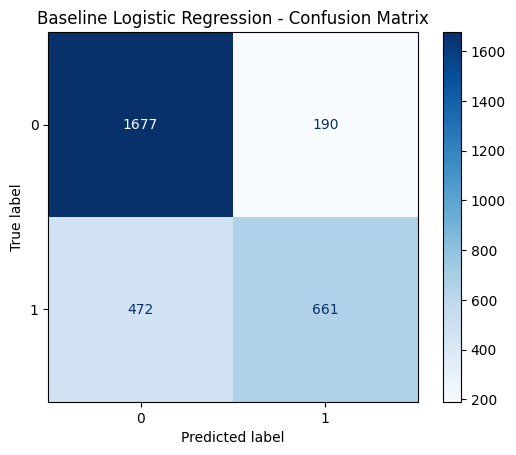

In [29]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Evaluate
print("Baseline Logistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"MSE:       {mean_squared_error(y_test, y_pred):.4f}")

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.show()

/tmp/ipykernel_266/530266029.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.values, y=coefficients.index, palette='coolwarm')


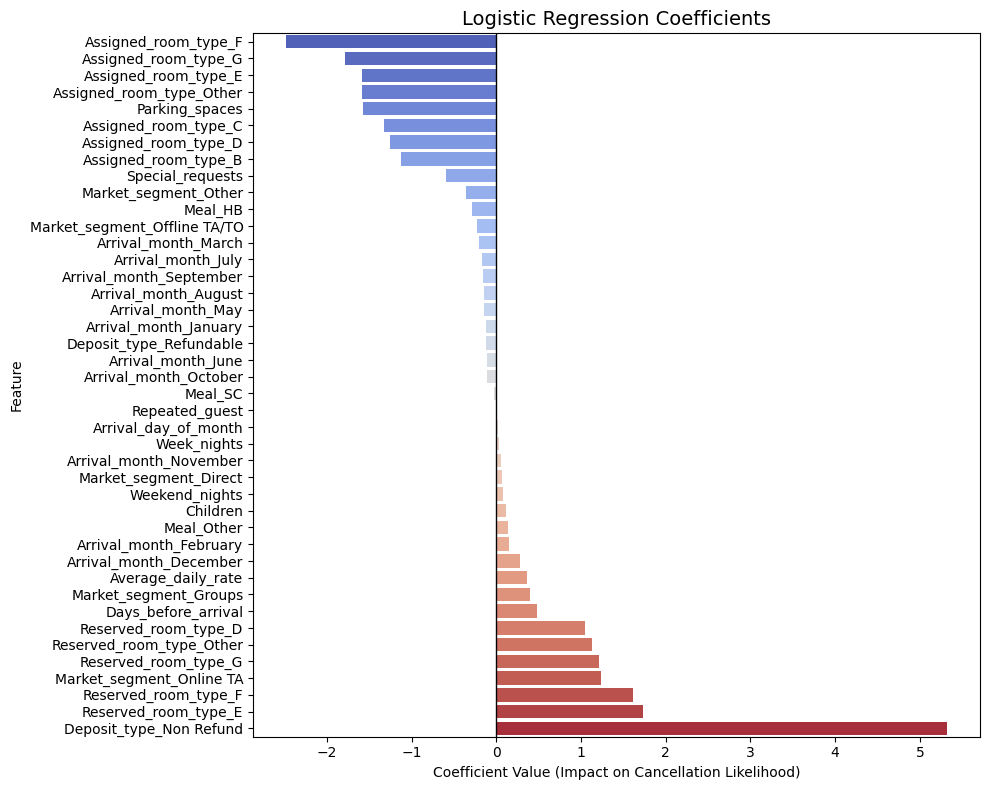

In [30]:
# Visualization of logistic regression coefficients
coefficients = pd.Series(log_reg.coef_[0], index=X_train.columns)
coefficients = coefficients.sort_values()

plt.figure(figsize=(10, 8))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='coolwarm')
plt.title("Logistic Regression Coefficients", fontsize=14)
plt.xlabel("Coefficient Value (Impact on Cancellation Likelihood)")
plt.ylabel("Feature")
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

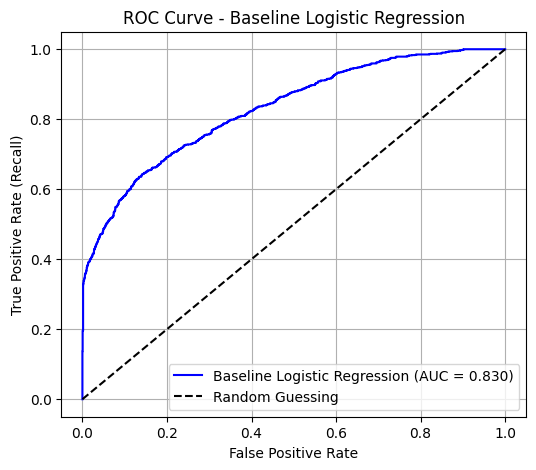

ROC AUC Score (Baseline Logistic Regression): 0.8301


In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (cancellations)
y_prob_base = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_base)
auc_base = roc_auc_score(y_test, y_prob_base)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Baseline Logistic Regression (AUC = {auc_base:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Baseline Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC Score (Baseline Logistic Regression): {auc_base:.4f}")



Tree-based models

Unpruned Decision Tree Performance:
Accuracy:  0.7393
Precision: 0.6456
Recall:    0.6867
F1 Score:  0.6655
ROC AUC:   0.7288
MSE:       0.2607
Avg Gini:  0.1823


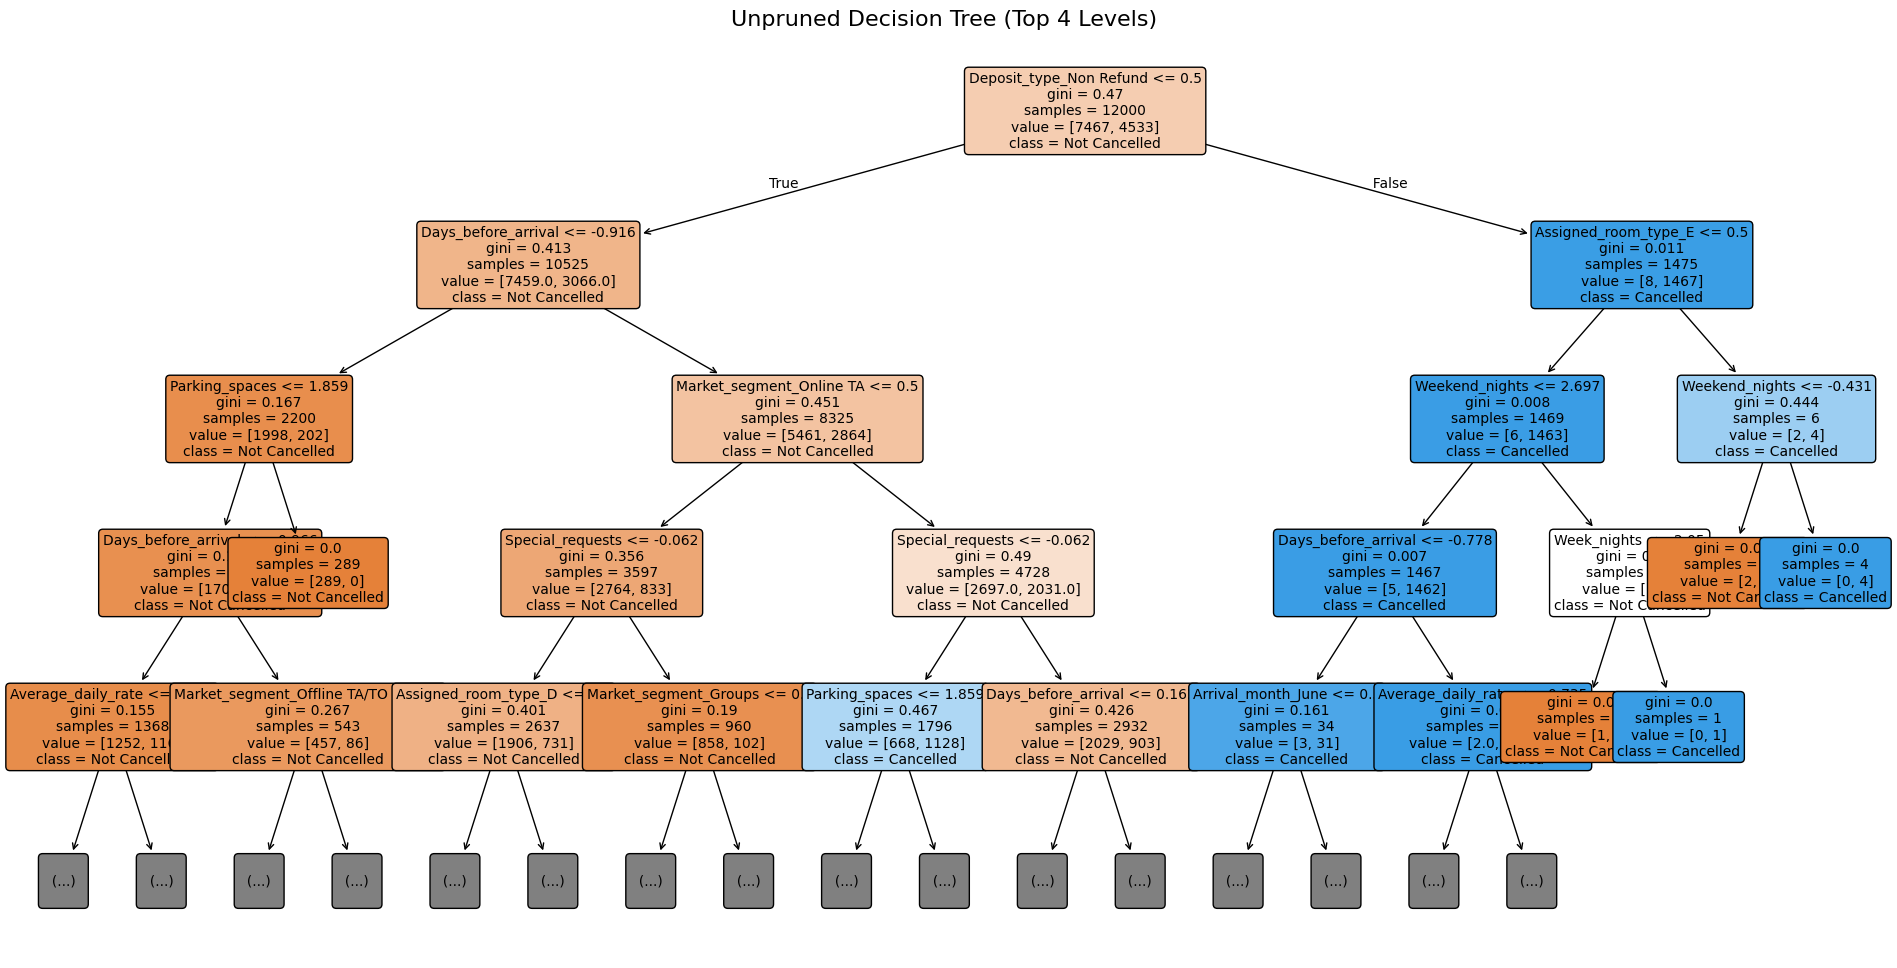

In [32]:
# Unpruned decision tree

# Train an UNPRUNED Decision Tree
tree_unpruned = DecisionTreeClassifier(
    criterion='gini',
    random_state=42
    # No max_depth, no min_samples_leaf → grows until fully pure
)
tree_unpruned.fit(X_train, y_train)

# Compute Gini impurity (after fitting)
gini_unpruned = tree_unpruned.tree_.impurity.mean()

# Predict
y_pred_unpruned = tree_unpruned.predict(X_test)
y_prob_unpruned = tree_unpruned.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_unpruned = accuracy_score(y_test, y_pred_unpruned)
precision_unpruned = precision_score(y_test, y_pred_unpruned)
recall_unpruned = recall_score(y_test, y_pred_unpruned)
f1_unpruned = f1_score(y_test, y_pred_unpruned)
roc_auc_unpruned = roc_auc_score(y_test, y_prob_unpruned)
mse_unpruned = mean_squared_error(y_test, y_pred_unpruned)

print("Unpruned Decision Tree Performance:")
print(f"Accuracy:  {accuracy_unpruned:.4f}")
print(f"Precision: {precision_unpruned:.4f}")
print(f"Recall:    {recall_unpruned:.4f}")
print(f"F1 Score:  {f1_unpruned:.4f}")
print(f"ROC AUC:   {roc_auc_unpruned:.4f}")
print(f"MSE:       {mse_unpruned:.4f}")
print(f"Avg Gini:  {gini_unpruned:.4f}")

# Visualize the top of the tree
plt.figure(figsize=(24, 12))
plot_tree(
    tree_unpruned,
    feature_names=X_train.columns,
    class_names=['Not Cancelled', 'Cancelled'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4    # show only top 4 levels for readability
)
plt.title("Unpruned Decision Tree (Top 4 Levels)", fontsize=16)
plt.show()


Decision Tree 1 (Balanced) Performance:
Accuracy:  0.7757
Precision: 0.7861
Recall:    0.5578
F1 Score:  0.6526
ROC AUC:   0.8169
MSE:       0.2243
Avg Gini:  0.2319


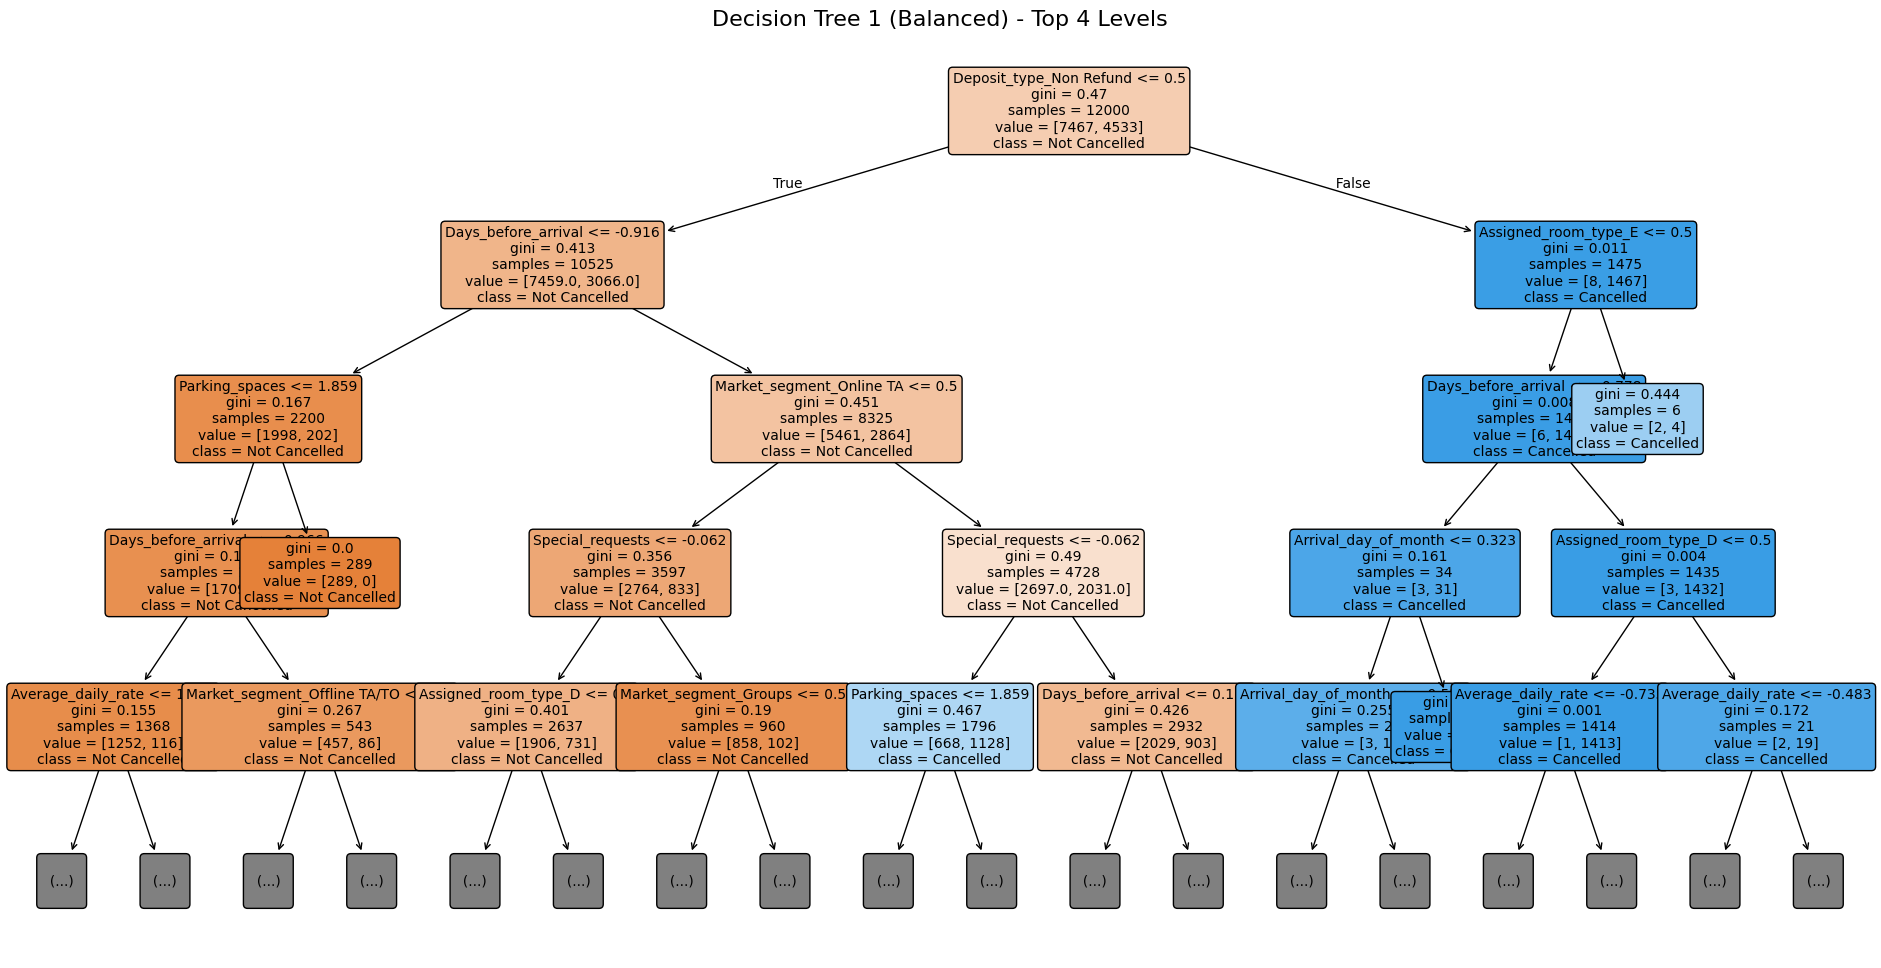

In [33]:
# Decision tree 1 (balanced)

# Train and Evaluate Decision Tree
tree1 = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=5,
    min_samples_leaf=5
)
tree1.fit(X_train, y_train)

# Compute gini after fitting
gini = tree1.tree_.impurity.mean()

# Predict
y_pred_tree = tree1.predict(X_test)
y_prob_tree = tree1.predict_proba(X_test)[:, 1]

# Evaluate
print("Decision Tree 1 (Balanced) Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tree):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tree):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"MSE:       {mean_squared_error(y_test, y_pred_tree):.4f}")
print(f"Avg Gini:  {gini:.4f}")

# Visualize
plt.figure(figsize=(24, 12))
plot_tree(
    tree1,
    feature_names=X_train.columns,
    class_names=['Not Cancelled', 'Cancelled'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4
)
plt.title("Decision Tree 1 (Balanced) - Top 4 Levels", fontsize=16)
plt.show()


Decision Tree 2 (Simpler) Performance:
Accuracy:  0.7443
Precision: 0.9867
Recall:    0.3274
F1 Score:  0.4917
ROC AUC:   0.7785
MSE:       0.2557
Avg Gini:  0.2159


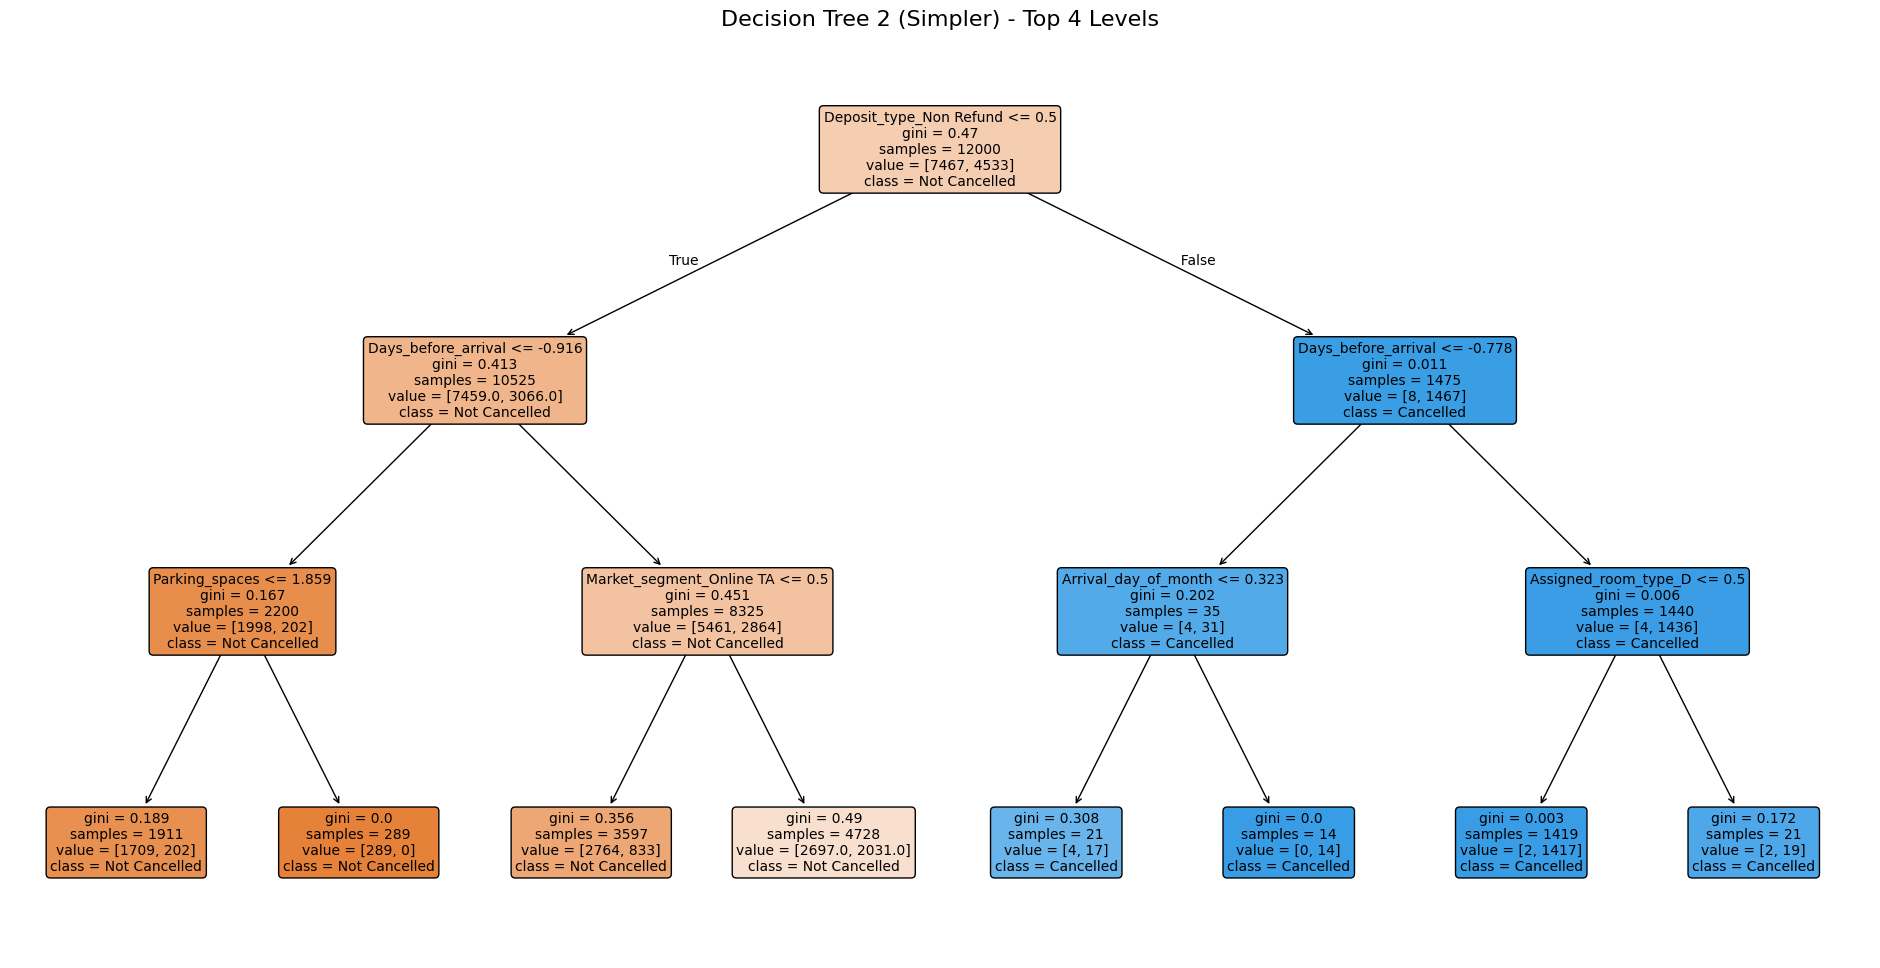

In [34]:
# Train and Evaluate Decision Tree
tree2 = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=3,
    min_samples_leaf=10
)
tree2.fit(X_train, y_train)

# Compute gini AFTER fitting
gini = tree2.tree_.impurity.mean()

# Predict
y_pred_tree = tree2.predict(X_test)
y_prob_tree = tree2.predict_proba(X_test)[:, 1]

# Evaluate
print("Decision Tree 2 (Simpler) Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tree):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tree):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"MSE:       {mean_squared_error(y_test, y_pred_tree):.4f}")
print(f"Avg Gini:  {gini:.4f}")

# Visualize
plt.figure(figsize=(24, 12))
plot_tree(
    tree2,
    feature_names=X_train.columns,
    class_names=['Not Cancelled', 'Cancelled'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4
)
plt.title("Decision Tree 2 (Simpler) - Top 4 Levels", fontsize=16)
plt.show()


Decision Tree 3 (More Complex) Performance:
Accuracy:  0.7817
Precision: 0.7859
Recall:    0.5799
F1 Score:  0.6673
ROC AUC:   0.8364
MSE:       0.2183
Avg Gini:  0.2661


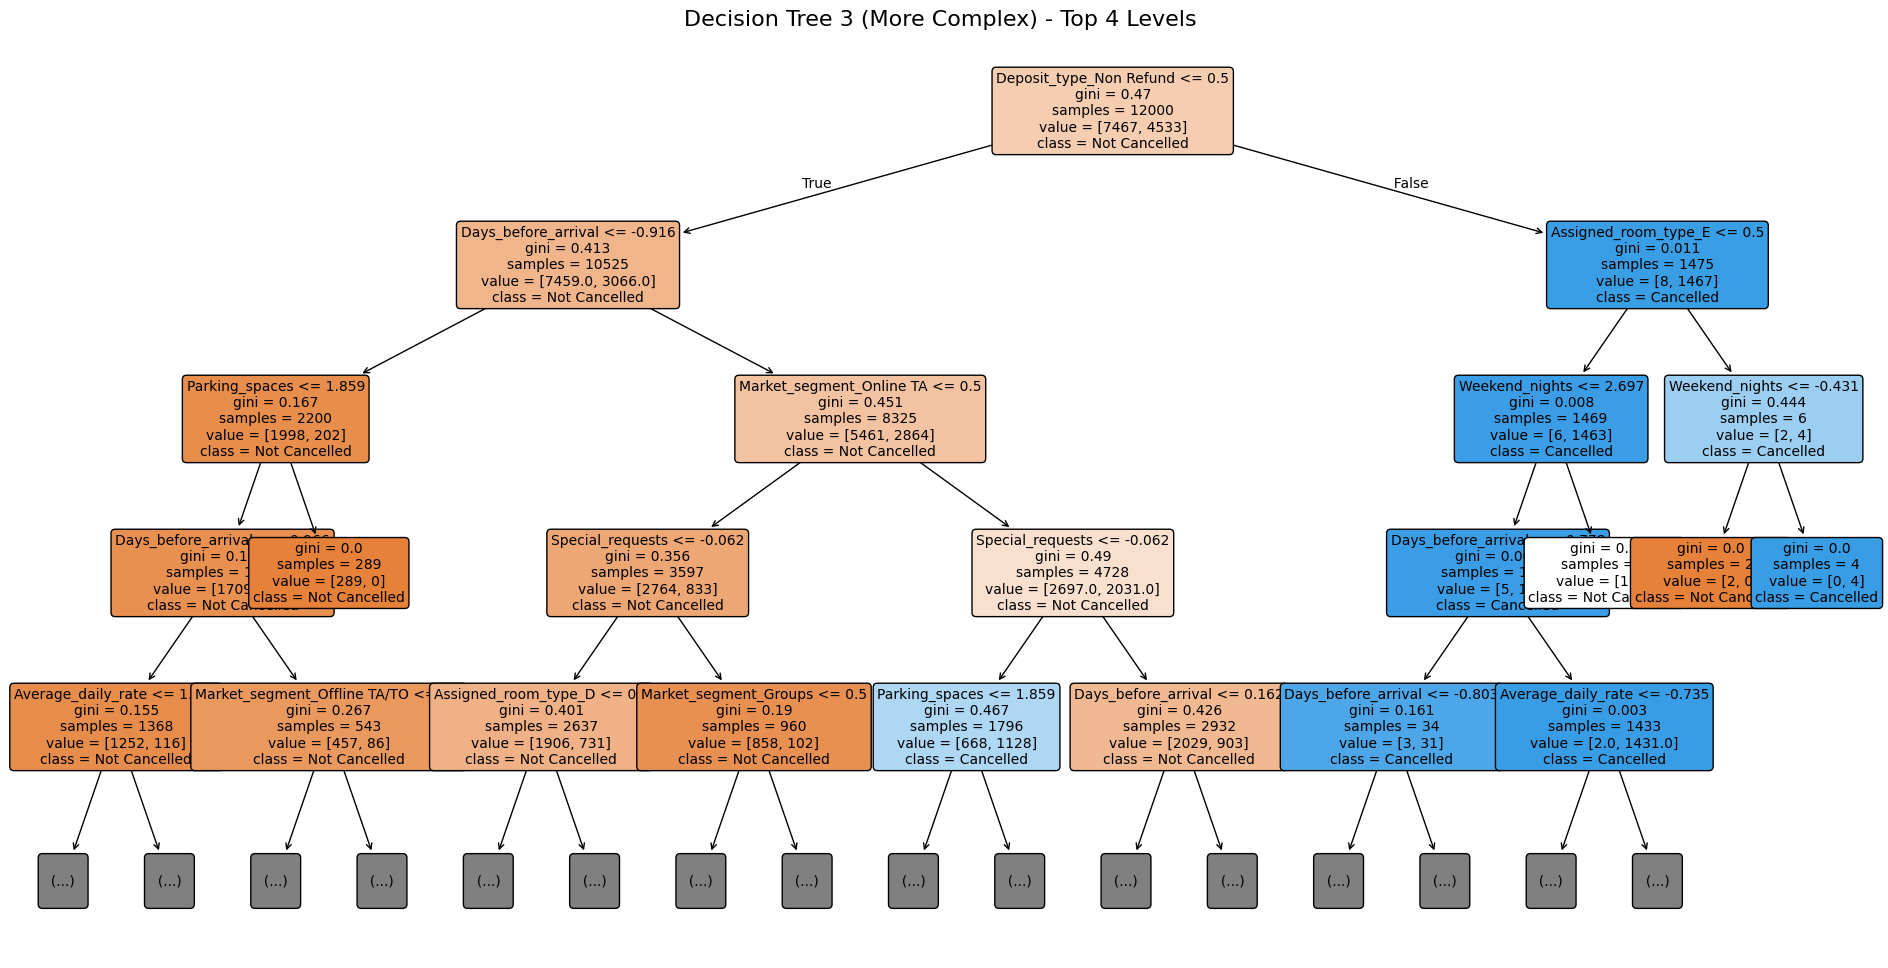

In [35]:
# Decision Tree 3 (More Complex)
# Train and Evaluate Decision Tree
tree3 = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=8,          # deeper, more complex model
    min_samples_leaf=2
)
tree3.fit(X_train, y_train)

# Compute Gini after fitting
gini = tree3.tree_.impurity.mean()

# Predict
y_pred_tree = tree3.predict(X_test)
y_prob_tree = tree3.predict_proba(X_test)[:, 1]

# Evaluate
print("Decision Tree 3 (More Complex) Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tree):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tree):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"MSE:       {mean_squared_error(y_test, y_pred_tree):.4f}")
print(f"Avg Gini:  {gini:.4f}")

# Visualize the Decision Tree
plt.figure(figsize=(24, 12))
plot_tree(
    tree3,
    feature_names=X_train.columns,
    class_names=['Not Cancelled', 'Cancelled'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4       # only top 4 levels for readability
)
plt.title("Decision Tree 3 (More Complex) - Top 4 Levels", fontsize=16)
plt.show()


In [36]:
# Train baseline Random Forest
rf_bl = RandomForestClassifier(random_state=42)
rf_bl.fit(X_train, y_train)

# Predict
y_pred_rf = rf_bl.predict(X_test)
y_prob_rf = rf_bl.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
mse = mean_squared_error(y_test, y_pred_rf)

# Average Gini impurity
gini_values = [estimator.tree_.impurity.mean() for estimator in rf_bl.estimators_]
avg_gini = np.mean(gini_values)

print("Baseline Random Forest Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"Avg Gini:  {avg_gini:.4f}")


Baseline Random Forest Performance:
Accuracy:  0.8077
Precision: 0.7970
Recall:    0.6584
F1 Score:  0.7211
ROC AUC:   0.8733
MSE:       0.1923
Avg Gini:  0.1830


In [37]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print("\n Best Parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Best Cross-Validated AUC: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_

# Predict
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)
mse_best = mean_squared_error(y_test, y_pred_best)

# Gini
gini_values = [estimator.tree_.impurity.mean() for estimator in best_rf.estimators_]
avg_gini_best = np.mean(gini_values)

print("\n Optimized Random Forest Performance:")
print(f"Accuracy:  {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall:    {recall_best:.4f}")
print(f"F1 Score:  {f1_best:.4f}")
print(f"ROC AUC:   {roc_auc_best:.4f}")
print(f"MSE:       {mse_best:.4f}")
print(f"Avg Gini:  {avg_gini_best:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits

 Best Parameters from Grid Search:
{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 300}
Best Cross-Validated AUC: 0.8794

 Optimized Random Forest Performance:
Accuracy:  0.8057
Precision: 0.8198
Recall:    0.6222
F1 Score:  0.7075
ROC AUC:   0.8715
MSE:       0.1943
Avg Gini:  0.2059


In [38]:
# Feture importance
# Starting off with the best performing decision tree
# We can see which variables play the biggest role in predicting cancellations

pd.Series(
    data=tree1.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)


Deposit_type_Non Refund         0.617522
Special_requests                0.129978
Days_before_arrival             0.127096
Market_segment_Online TA        0.077282
Parking_spaces                  0.026338
Assigned_room_type_D            0.016378
Market_segment_Groups           0.001481
Market_segment_Offline TA/TO    0.001366
Average_daily_rate              0.001352
Assigned_room_type_E            0.000625
Arrival_day_of_month            0.000581
Arrival_month_August            0.000000
Week_nights                     0.000000
Children                        0.000000
Weekend_nights                  0.000000
Repeated_guest                  0.000000
Arrival_month_December          0.000000
Arrival_month_February          0.000000
Arrival_month_November          0.000000
Arrival_month_May               0.000000
Arrival_month_October           0.000000
Arrival_month_September         0.000000
Arrival_month_June              0.000000
Arrival_month_March             0.000000
Arrival_month_Ja

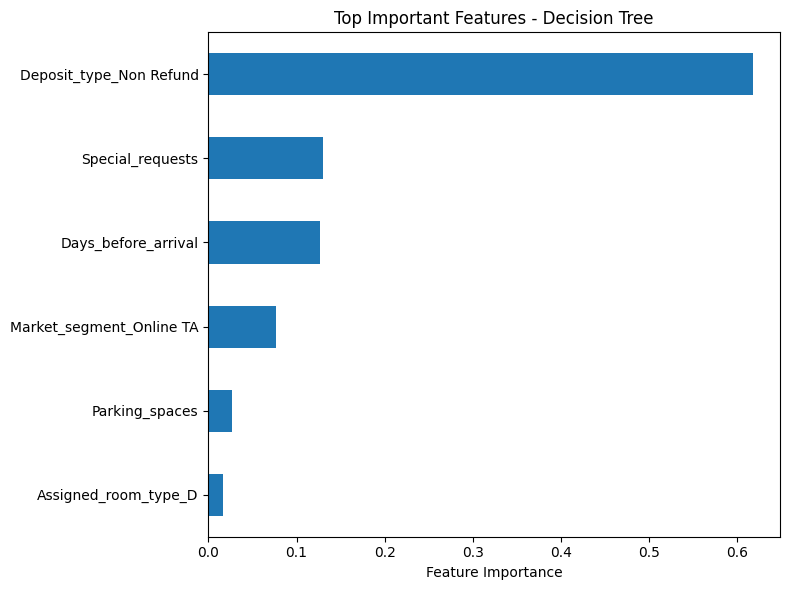

In [39]:
# Fetaure importance XAI dtree
dt_importance = pd.Series(
    data=tree1.feature_importances_,
    index=X_train.columns
).sort_values(ascending=True).tail(6)

plt.figure(figsize=(8,6))
dt_importance.plot(kind='barh')
plt.title("Top Important Features - Decision Tree")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [40]:
# Feature importance random forest

pd.Series(
    data=best_rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)


Deposit_type_Non Refund         0.250838
Days_before_arrival             0.168578
Special_requests                0.089806
Average_daily_rate              0.089573
Arrival_day_of_month            0.049988
Week_nights                     0.036682
Market_segment_Online TA        0.036061
Parking_spaces                  0.033936
Market_segment_Groups           0.031913
Weekend_nights                  0.023233
Assigned_room_type_D            0.020853
Market_segment_Offline TA/TO    0.017857
Market_segment_Direct           0.016776
Reserved_room_type_D            0.011370
Meal_HB                         0.009749
Children                        0.008271
Arrival_month_July              0.007207
Arrival_month_August            0.006982
Assigned_room_type_E            0.006302
Arrival_month_May               0.006212
Arrival_month_September         0.005849
Meal_SC                         0.005369
Reserved_room_type_E            0.005073
Arrival_month_June              0.005023
Arrival_month_De

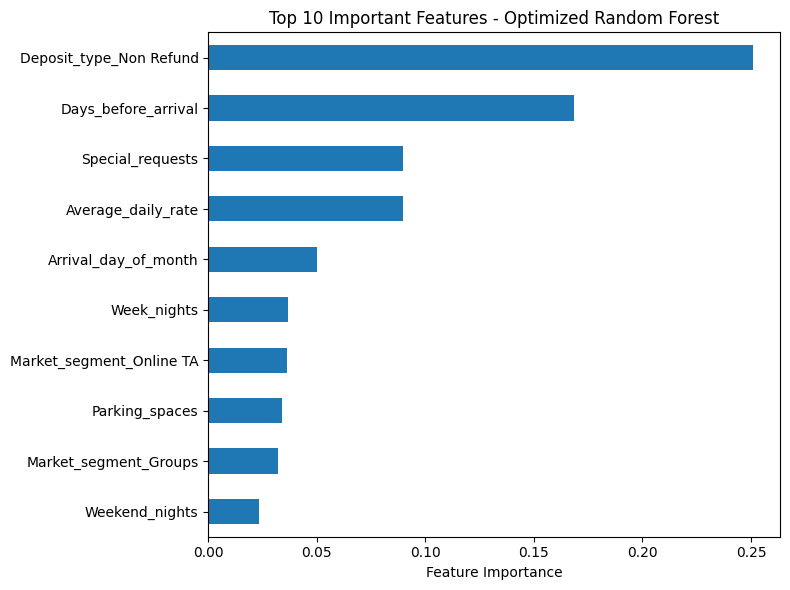

In [41]:
# Feature importance xai rf
rf_importance = pd.Series(
    data=best_rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=True).tail(10)

plt.figure(figsize=(8,6))
rf_importance.plot(kind='barh')
plt.title("Top 10 Important Features - Optimized Random Forest")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

Neural Networks

In [42]:
# Ensure numeric and clean
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test  = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_test_tensor  = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor  = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Build Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)


In [43]:
# Define neural networks
class MediumNet(nn.Module):
    def __init__(self, input_dim):
        super(MediumNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

input_dim = X_train.shape[1]
model = MediumNet(input_dim)
print(model)



MediumNet(
  (fc1): Linear(in_features=42, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [44]:
# Testing best learning rate
lrs = [0.1, 0.01, 0.001, 0.0001]
results = []

for lr in lrs:
    torch.manual_seed(SEED)
    model = MediumNet(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(20):  # fewer epochs just for comparison
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_tensor).numpy()
        y_pred = (y_prob > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
    
    results.append((lr, acc))

# Display results
for lr, acc in results:
    print(f"Learning Rate: {lr} → Accuracy: {acc:.4f}")


[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=300; total time=   0.9s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=300; total time=   0.9s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=200; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=300; total time=   0.9s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=300; total time=   1.4s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   0.9s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END .max_depth=15, min_

In [45]:
# Define loss function, optimizer and metric
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Accuracy metric using torchmetrics
accuracy_metric = torchmetrics.Accuracy(task="binary")


In [46]:
# Training loop
epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

        preds = (val_outputs > 0.5).int()
        val_accuracy = accuracy_metric(preds, y_test_tensor.int()).item()
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")


Epoch [10/50] | Train Loss: 0.3952 | Val Loss: 0.4531 | Val Acc: 0.7823
Epoch [20/50] | Train Loss: 0.3677 | Val Loss: 0.4909 | Val Acc: 0.7887
Epoch [30/50] | Train Loss: 0.3452 | Val Loss: 0.4998 | Val Acc: 0.7893
Epoch [40/50] | Train Loss: 0.3308 | Val Loss: 0.5096 | Val Acc: 0.7800
Epoch [50/50] | Train Loss: 0.3189 | Val Loss: 0.5550 | Val Acc: 0.7757


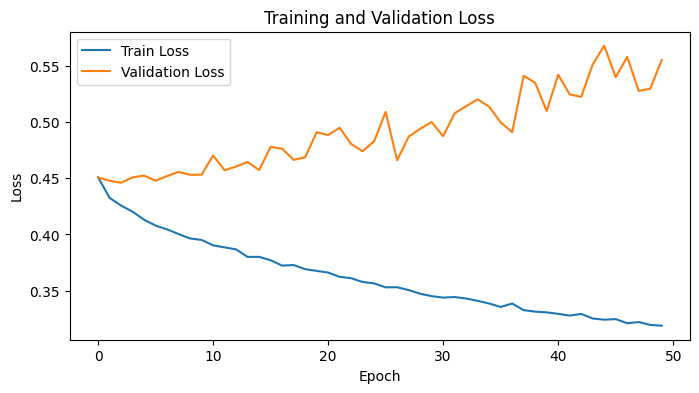

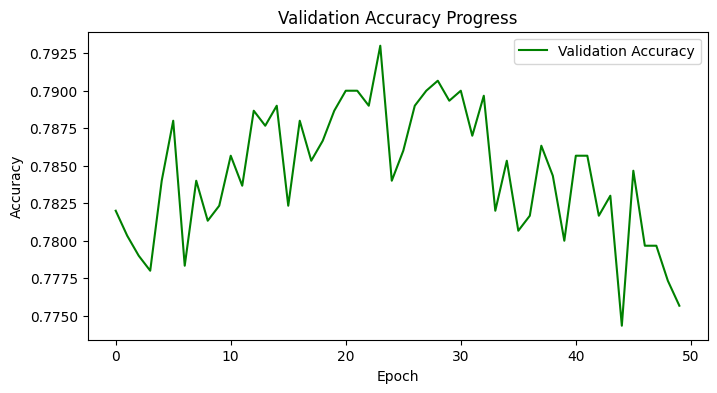

In [47]:
# Plot training and validation process
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Progress')
plt.legend()
plt.show()


In [48]:
# Evaluate model performance
model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor).numpy()
    y_pred = (y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mse = mean_squared_error(y_test, y_pred)

print("\nNeural Network Performance")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"MSE:       {mse:.4f}")



Neural Network Performance
Accuracy:  0.7757
Precision: 0.7357
Recall:    0.6337
F1 Score:  0.6809
ROC AUC:   0.8422
MSE:       0.2243


SmallNet(
  (fc1): Linear(in_features=42, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch [10/50] | Train Loss: 0.4288 | Val Loss: 0.4505 | Val Acc: 0.7807
Epoch [20/50] | Train Loss: 0.4184 | Val Loss: 0.4446 | Val Acc: 0.7807
Epoch [30/50] | Train Loss: 0.4129 | Val Loss: 0.4406 | Val Acc: 0.7847
Epoch [40/50] | Train Loss: 0.4093 | Val Loss: 0.4403 | Val Acc: 0.7860
Epoch [50/50] | Train Loss: 0.4055 | Val Loss: 0.4406 | Val Acc: 0.7870


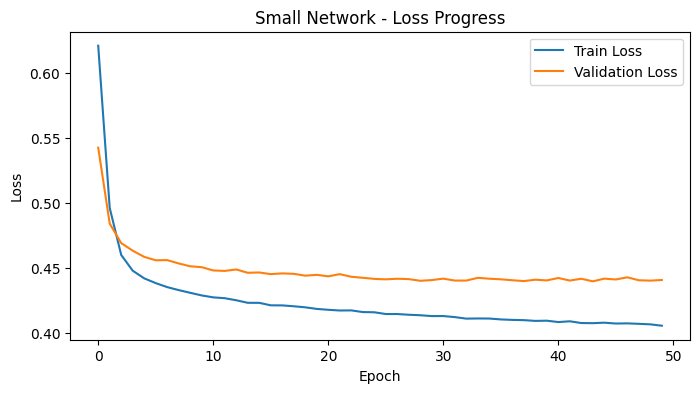

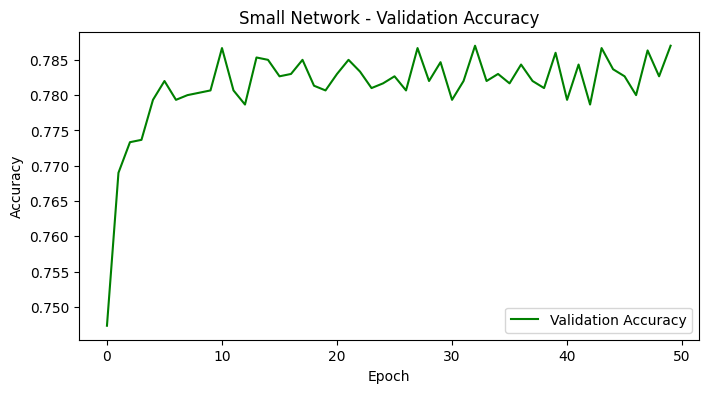


 Small Neural Network Performance:
Accuracy:  0.7870
Precision: 0.7813
Recall:    0.6055
F1 Score:  0.6822
ROC AUC:   0.8485
MSE:       0.2130


In [49]:
# Smaller NN
class SmallNet(nn.Module):
    def __init__(self, input_dim):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize model
torch.manual_seed(SEED)
input_dim = X_train.shape[1]
model = SmallNet(input_dim)
print(model)

# Define loss, optimizer, and metric
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = torchmetrics.Accuracy(task="binary")

# Training loop
epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

        preds = (val_outputs > 0.5).int()
        val_accuracy = accuracy_metric(preds, y_test_tensor.int()).item()

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# Plot training progress
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Small Network - Loss Progress')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()
plt.figure(figsize=(8,4))
plt.plot(val_accuracies, color='green', label='Validation Accuracy')
plt.title('Small Network - Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor).numpy()
    y_pred = (y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mse = mean_squared_error(y_test, y_pred)

print("\n Small Neural Network Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"MSE:       {mse:.4f}")



DeepNet(
  (fc1): Linear(in_features=42, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch [10/50] | Train Loss: 0.3984 | Val Loss: 0.4550 | Val Acc: 0.7803
Epoch [20/50] | Train Loss: 0.3724 | Val Loss: 0.4666 | Val Acc: 0.7790
Epoch [30/50] | Train Loss: 0.3465 | Val Loss: 0.4675 | Val Acc: 0.7857
Epoch [40/50] | Train Loss: 0.3283 | Val Loss: 0.4920 | Val Acc: 0.7757
Epoch [50/50] | Train Loss: 0.3056 | Val Loss: 0.5159 | Val Acc: 0.7847


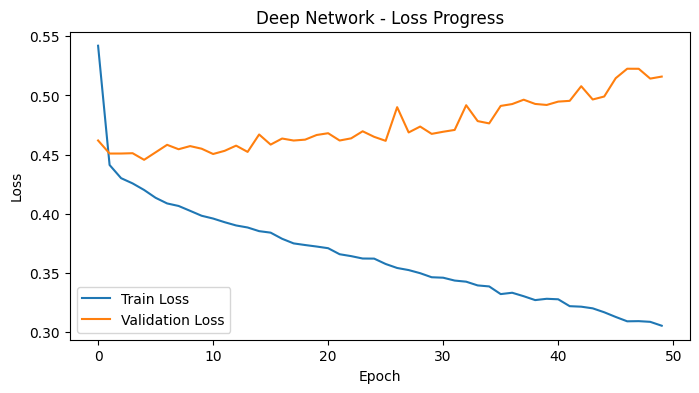

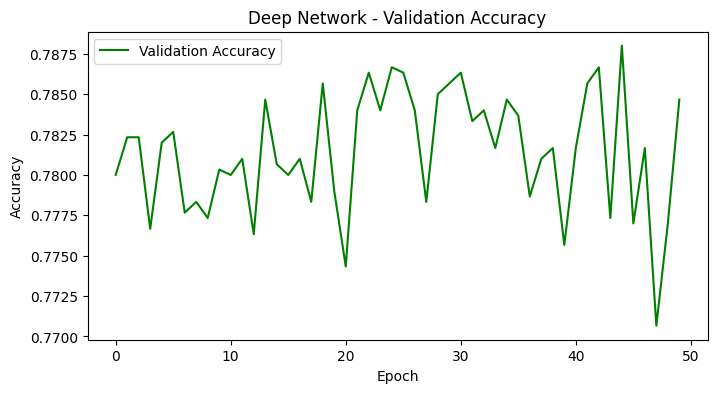


 Deep Neural Network Performance:
Accuracy:  0.7847
Precision: 0.7423
Recall:    0.6584
F1 Score:  0.6978
ROC AUC:   0.8493
MSE:       0.2153


In [50]:
class DeepNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize model
torch.manual_seed(SEED)
model = DeepNet(input_dim)
print(model)

# Define loss, optimizer, and metric
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = torchmetrics.Accuracy(task="binary")

# Training loop
epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

        preds = (val_outputs > 0.5).int()
        val_accuracy = accuracy_metric(preds, y_test_tensor.int()).item()

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# Plot training progress
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Deep Network - Loss Progress')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, color='green', label='Validation Accuracy')
plt.title('Deep Network - Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor).numpy()
    y_pred = (y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
mse = mean_squared_error(y_test, y_pred)

print("\n Deep Neural Network Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"MSE:       {mse:.4f}")


Base ROC-AUC: 0.8493


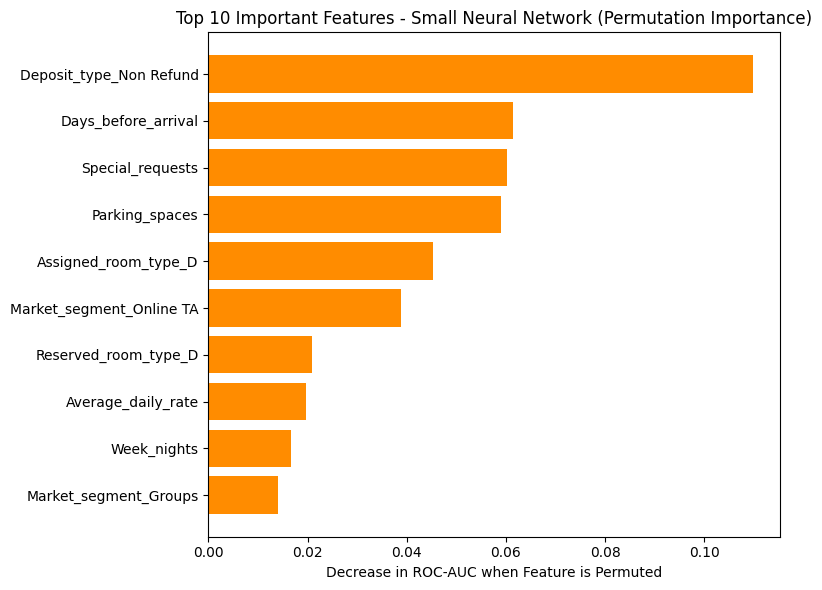

In [51]:
# Neural network feature importance xai

# Make sure test data is numeric and aligned
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Helper function to get predictions from your trained SmallNet
def nn_predict(X):
    X_numeric = np.array(X, dtype=np.float32)
    with torch.no_grad():
        X_tensor = torch.tensor(X_numeric, dtype=torch.float32)
        outputs = model(X_tensor)   # use your trained 'model'
        return outputs.numpy().flatten()

# Compute base AUC before permutation
base_pred = nn_predict(X_test_numeric.values)
base_auc = roc_auc_score(y_test, base_pred)
print(f"Base ROC-AUC: {base_auc:.4f}")

# Compute permutation importance for each feature
importances = []
for col in X_test_numeric.columns:
    X_permuted = X_test_numeric.copy()
    X_permuted[col] = np.random.permutation(X_permuted[col])
    perm_pred = nn_predict(X_permuted.values)
    perm_auc = roc_auc_score(y_test, perm_pred)
    importances.append(base_auc - perm_auc)

# Store and sort importance values
feat_importance = pd.DataFrame({
    'Feature': X_test_numeric.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 10 features
top_features = feat_importance.head(10).sort_values('Importance', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(top_features['Feature'], top_features['Importance'], color='darkorange')
plt.title("Top 10 Important Features - Small Neural Network (Permutation Importance)")
plt.xlabel("Decrease in ROC-AUC when Feature is Permuted")
plt.tight_layout()
plt.show()


Market basket analysis

In [52]:
# Pick the clean dataframe
try:
    df_ba = df_clean.copy()
except NameError:
    df_ba = df.copy()

# Keep only cancelled bookings (Target == 1)
df_ba = df_ba[df_ba['Target'] == 1].reset_index(drop=True)
print("Rows (cancelled only):", len(df_ba))

Rows (cancelled only): 5666


In [53]:
# Identify categorical & numeric candidates
cat_cols = [c for c in df_ba.columns if df_ba[c].dtype == 'object']
num_cols = [c for c in df_ba.columns if str(df_ba[c].dtype).startswith(('int','float'))]

# keep the booking-related categoricals that I care about:
likely_cats = [c for c in cat_cols if c.lower() not in {'reservation_status','reservation_status_date'}]

# Among numerics, discretize only “continuous-like” ones (>=10 unique values)
cont_like = [c for c in num_cols if df_ba[c].nunique(dropna=True) >= 10]

# Example: ensure these commonly relevant variables are included
for preferred in ['Days_before_arrival', 'Average_daily_rate', 'Week_nights', 'Weekend_nights']:
    if preferred in df_ba.columns and preferred not in cont_like:
        cont_like.append(preferred)

# Discretize to tertiles (Low/Med/High); guard against constant columns
def safe_qcut(s, q=3, labels=('Low','Med','High')):
    try:
        return pd.qcut(s, q=q, labels=labels, duplicates='drop')
    except ValueError:
        # fallback if not enough unique values
        return pd.cut(s, bins=np.unique(np.nanpercentile(s, [0,33.33,66.66,100])) , include_lowest=True, labels=labels[:len(np.unique(np.nanpercentile(s, [0,33.33,66.66,100])))-1])

df_disc = df_ba.copy()
disc_cols_done = []
for c in cont_like:
    try:
        df_disc[c] = safe_qcut(df_ba[c])
        disc_cols_done.append(c)
    except Exception:
        pass

print("Discretized numeric columns:", disc_cols_done)
print("Categorical columns used as-is (sample):", likely_cats[:8])


Discretized numeric columns: ['Days_before_arrival', 'Arrival_day_of_month', 'Average_daily_rate', 'Week_nights', 'Weekend_nights']
Categorical columns used as-is (sample): ['Arrival_month', 'Meal', 'Market_segment', 'Reserved_room_type', 'Assigned_room_type', 'Deposit_type']


In [54]:
# Columns that will form items:
use_cols = list(set(likely_cats + disc_cols_done))

# Create "Feature=Value" strings per row
def row_to_items(row, cols):
    items = []
    for c in cols:
        val = row[c]
        if pd.notna(val):
            items.append(f"{c}={val}")
    return items

transactions = df_disc[use_cols].apply(lambda r: row_to_items(r, use_cols), axis=1).tolist()
transactions[:2][:]


[['Arrival_month=September',
  'Assigned_room_type=A',
  'Week_nights=High',
  'Days_before_arrival=High',
  'Deposit_type=Non Refund',
  'Weekend_nights=Med',
  'Meal=HB',
  'Market_segment=Groups',
  'Arrival_day_of_month=High',
  'Average_daily_rate=Low',
  'Reserved_room_type=A'],
 ['Arrival_month=October',
  'Assigned_room_type=A',
  'Week_nights=Low',
  'Days_before_arrival=High',
  'Deposit_type=Non Refund',
  'Weekend_nights=Low',
  'Meal=BB',
  'Market_segment=Offline TA/TO',
  'Arrival_day_of_month=Med',
  'Average_daily_rate=Med',
  'Reserved_room_type=A']]

In [55]:
# Transaction to one-hot matrix
te = TransactionEncoder().fit(transactions)
encoded = te.transform(transactions)
df_trans = pd.DataFrame(encoded, columns=te.columns_)
print("Transactional shape:", df_trans.shape)

# First pass: frequent itemsets (tryin a few supports; max_len<=3 keeps it readable)
freq_02 = apriori(df_trans, min_support=0.02, use_colnames=True, max_len=3)
freq_05 = apriori(df_trans, min_support=0.05, use_colnames=True, max_len=3)

print("Frequent itemsets @2%:", len(freq_02), " | @5%:", len(freq_05))

# Focusing on non-trivial combos (length >= 2) and sort by support
top_itemsets = (freq_02.assign(length=freq_02['itemsets'].apply(len))
                           .query('length >= 2')
                           .sort_values('support', ascending=False)
                           .head(15))
top_itemsets


Transactional shape: (5666, 53)
Frequent itemsets @2%: 2579  | @5%: 1148


,support,itemsets,length
317,0.745852,"(Reserved_room_type=A, Assigned_room_type=A)",2
503,0.578009,"(Reserved_room_type=A, Meal=BB)",2
1838,0.567949,"(Reserved_room_type=A, Assigned_room_type=A, M...",3
314,0.567949,"(Meal=BB, Assigned_room_type=A)",2
523,0.557889,"(Reserved_room_type=A, Weekend_nights=Low)",2
509,0.556830,"(Weekend_nights=Low, Meal=BB)",2
1855,0.549594,"(Reserved_room_type=A, Assigned_room_type=A, W...",3
321,0.549594,"(Weekend_nights=Low, Assigned_room_type=A)",2
450,0.502471,"(Meal=BB, Deposit_type=No Deposit)",2
521,0.499824,"(Reserved_room_type=A, Week_nights=Low)",2


In [56]:
# Rules based on the 2% support itemsets
rules = association_rules(freq_02, metric="lift", min_threshold=1.0)

# Add sizes for filtering convenience
rules['ante_len'] = rules['antecedents'].apply(len)
rules['cons_len'] = rules['consequents'].apply(len)

# Keep non-trivial rules: both sides non-empty and not just single “obvious” fields
rules_strong = (
    rules.query('ante_len >= 1 and cons_len >= 1')
         .query('confidence >= 0.60 and lift >= 1.10')
         .sort_values(['lift','confidence','support'], ascending=[False, False, False])
         .head(25)
)

# Make them readable
def set_to_str(s): return ', '.join(sorted(list(s)))
rules_strong = rules_strong.assign(
    antecedents_str=rules_strong['antecedents'].apply(set_to_str),
    consequents_str=rules_strong['consequents'].apply(set_to_str)
)[['antecedents_str','consequents_str','support','confidence','lift']]

rules_strong


,antecedents_str,consequents_str,support,confidence,lift
5964,"Assigned_room_type=E, Weekend_nights=Med",Reserved_room_type=E,0.021708,0.976190,20.715713
5907,"Assigned_room_type=E, Average_daily_rate=High",Reserved_room_type=E,0.027886,0.963415,20.444597
5947,"Assigned_room_type=E, Market_segment=Online TA",Reserved_room_type=E,0.033180,0.959184,20.354812
5950,Reserved_room_type=E,"Assigned_room_type=E, Market_segment=Online TA",0.033180,0.704120,20.354812
5963,"Reserved_room_type=E, Weekend_nights=Med",Assigned_room_type=E,0.021708,1.000000,20.308244
5906,"Average_daily_rate=High, Reserved_room_type=E",Assigned_room_type=E,0.027886,0.993711,20.180519
5946,"Market_segment=Online TA, Reserved_room_type=E",Assigned_room_type=E,0.033180,0.989474,20.094473
5951,Assigned_room_type=E,"Market_segment=Online TA, Reserved_room_type=E",0.033180,0.673835,20.094473
346,Reserved_room_type=E,Assigned_room_type=E,0.046594,0.988764,20.080061
347,Assigned_room_type=E,Reserved_room_type=E,0.046594,0.946237,20.080061


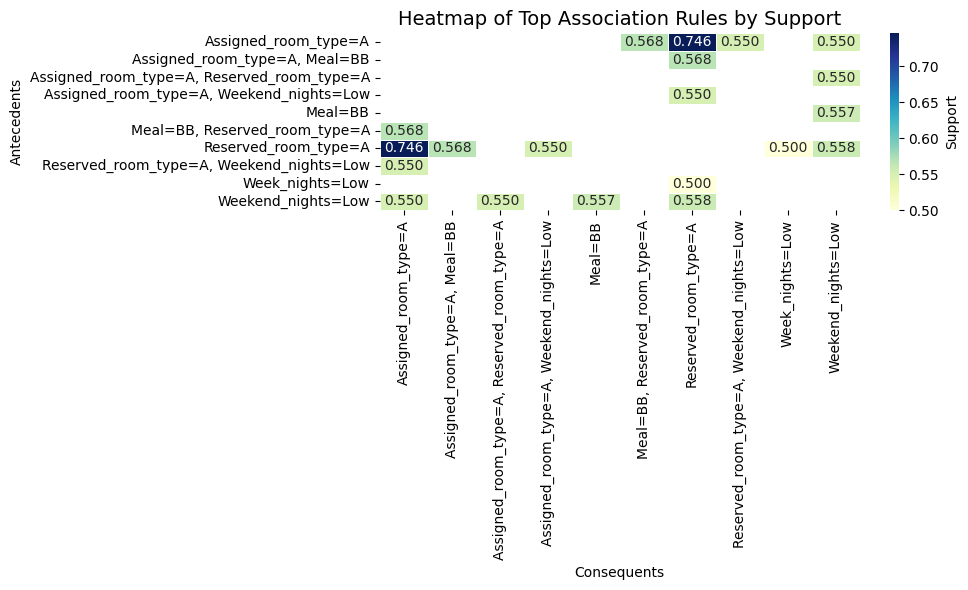

In [57]:
# Top use heat map support matrix

# Select top N rules by support (adjust number as needed)
top_rules_support = rules.sort_values('support', ascending=False).head(20)

# Build a compact pivot table
pivot_support = top_rules_support.pivot_table(
    values='support',
    index=top_rules_support['antecedents'].apply(lambda x: ', '.join(sorted(list(x)))),
    columns=top_rules_support['consequents'].apply(lambda x: ', '.join(sorted(list(x))))
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_support,
    annot=True,
    cmap='YlGnBu',          # Green-blue color palette
    linewidths=0.5,
    fmt=".3f",              # Show support values with 3 decimals
    cbar_kws={'label': 'Support'}
)
plt.title('Heatmap of Top Association Rules by Support', fontsize=14)
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.tight_layout()
plt.show()



Text analytics

In [58]:
# Overview of the dataframe
df_text.head()

,Review,Rating
0,great location wife recently spent second week...,4
1,loved breakers stayed breakers recommendation ...,5
2,"nice hotel girlfriend booked hotel students, d...",4
3,"terrible customer service second stay resort, ...",1
4,"old style waikiki, reading reviews tripadvisor...",5


In [59]:
# basic preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

df_text['cleaned_review'] = df_text['Review'].apply(clean_text)
df_text.head()


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review,Rating,cleaned_review
0,great location wife recently spent second week...,4,great location wife recently spent second week...
1,loved breakers stayed breakers recommendation ...,5,loved breakers stayed breakers recommendation ...
2,"nice hotel girlfriend booked hotel students, d...",4,"nice hotel girlfriend booked hotel students, n..."
3,"terrible customer service second stay resort, ...",1,"terrible customer service second stay resort, ..."
4,"old style waikiki, reading reviews tripadvisor...",5,"old style waikiki, reading reviews tripadvisor..."


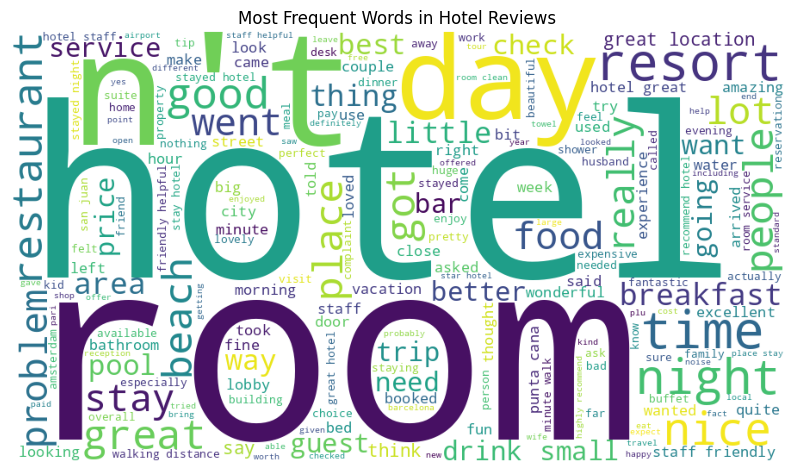

In [60]:
# Wordcloud form most frquent items

all_text = " ".join(df_text['cleaned_review'])
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most Frequent Words in Hotel Reviews")
plt.show()


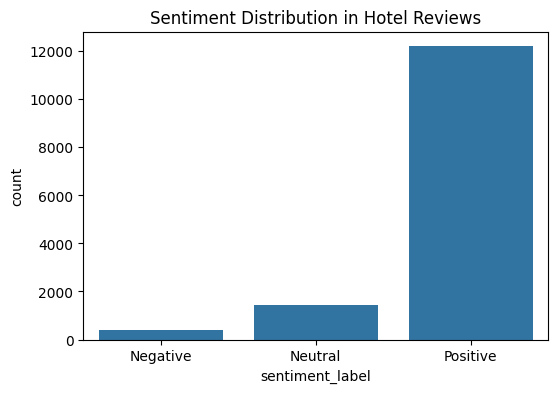

In [61]:
 # Sentiment estimation

df_text['sentiment'] = df_text['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_text['sentiment_label'] = pd.cut(
    df_text['sentiment'],
    bins=[-1, -0.1, 0.1, 1],
    labels=['Negative', 'Neutral', 'Positive']
)

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_label', data=df_text)
plt.title("Sentiment Distribution in Hotel Reviews")
plt.show()


In [62]:
# Check examples
n = 10
print('Review:', df_text['cleaned_review'].iloc[n])
print('Sentiment score:', df_text['sentiment'].iloc[n])
print('Label:', df_text['sentiment_label'].iloc[n])


Review: great budget hotel stayed days hotel second weekend jazzfest pleasantly surprised, room spacious exceptionally clean, desk cleaning people nice willing help, roaches room reported previous post, ihop convenient, budget hotel place exceeded expections,
Sentiment score: 0.2785714285714286
Label: Positive


Correlation between Rating and Sentiment: 0.63


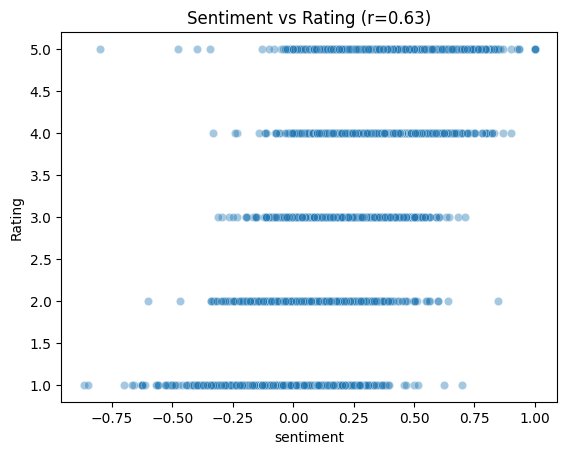

In [63]:
# Relationship between sentiment and rating
corr = df_text[['Rating', 'sentiment']].corr().iloc[0,1]
print(f"Correlation between Rating and Sentiment: {corr:.2f}")

sns.scatterplot(x='sentiment', y='Rating', data=df_text, alpha=0.4)
plt.title(f"Sentiment vs Rating (r={corr:.2f})")
plt.show()


In [64]:
# Topic modelling (LDA)

vect = CountVectorizer(stop_words='english')
review_counts = vect.fit_transform(df_text['cleaned_review'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda_results = lda.fit_transform(review_counts)

# Print 10 most important words per topic
for topic, comp in enumerate(lda.components_):
    words_sorted = np.argsort(comp)[-10:]
    print(f"\nTopic {topic+1}:")
    print([vect.get_feature_names_out()[i] for i in words_sorted])



Topic 1:
['people', 'day', 'room', 'time', 'pool', 'good', 'great', 'food', 'resort', 'beach']

Topic 2:
['like', 'bed', 'desk', 'rooms', 'service', 'staff', 'night', 'stay', 'hotel', 'room']

Topic 3:
['stayed', 'clean', 'breakfast', 'stay', 'good', 'staff', 'location', 'room', 'great', 'hotel']
